In [819]:
import geopy
from geopy.extra.rate_limiter import RateLimiter


import pandas as pd
import numpy as np
import geopandas as gpd

from matplotlib import pyplot as plt
import shapely

%matplotlib inline

import contextily as ctx
import requests
import plotly.express as px
from zipfile import ZipFile
import json
import random
import os, urllib
import seaborn as sbn

#from tqdm.auto import tqdm, trange
from tqdm import tqdm, trange
tqdm.pandas()

from geopy_nominatim_wrapper import NominatimWrapper
from geopy_bestaddress import BestAddress
from geopy_pelias import Pelias
from geopy_ngipelias import NGIPelias


from credentials import (here_api_key, 
                         bing_api_key, 
                         mapbox_api_key, 
                         tomtom_api_key, 
                         google_api_key, 
                         best_client_id, best_client_secret, best_hostname)



fig_path = "output/geocoding/figs"
data_dir = "data/geocoding"
output_dir="output/geocoding/"
# from fpdf import FPDF 

In [820]:
# dataset = "rrn_1000"
# dataset = "kbo_1000"
dataset = "best_1000"
# dataset = "best2_1000"
# dataset = "rep_1000"
# dataset = "resto_1000"

In [821]:
crs =     'epsg:3857'
osm_crs=  'epsg:4326'

In [822]:
os.makedirs(f"{output_dir}/geocoded_data/", exist_ok=True)
os.makedirs(f"{output_dir}/reports/", exist_ok=True)
os.makedirs(fig_path, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)


In [823]:
def add_basemap(ax, zoom='auto'):
    """
    Add a basemap on a plot. Tries first default (Stamen) basemap. If errors, tries OpenStreetMap.Mapnik
    
    Parameters
    ----------
    ax: matplotlib axes
    
    Returns
    -------
        None
    """

    try: 
        ctx.add_basemap(ax, zoom=zoom)
    except requests.HTTPError:
        print("Default basemap doesn't work...")
        ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=zoom)

In [824]:
def set_optimal_limits(ax, df):
    """
    Adapt xlim/ylim to a GeoDataFrame point plot to avoid plot to be too wide when 
    points are horizontally aligned, and to narrow when points are vertically aligned

    Usage : 
    
    ax = df.plot()
    set_optimal_limits(ax, df)
    
    Parameters
    ----------
    ax: AxesSubplot
       plot to resize
    df: GeoDataFrame
       data to be plotted

    Returns
    -------
        None
    """
    
    plot_ratio = 1.5 # optimal ratio between "one horizontal degree" and "one vertical degree". It depends of the CRS. 
                     # For "polar" CRS, it may also depend of the place on the globe

    minimal_width=200
   
    margins = 1.1 # Avoid having dots on edges of the plot
    

    # Compute dimension of the data
    xmin, ymin, xmax, ymax = df.total_bounds
    height = (ymax - ymin) 
    width = (xmax - xmin)
    
    opt_height = max(height, width / plot_ratio, minimal_width / plot_ratio)
    opt_width  = max(width , height*plot_ratio, minimal_width)
    
#     print(xmin, ymin, xmax, ymax)
#     print(width, height, opt_width, opt_height)
    # If plot is too narrow, increase xmin. If plot is too wide, increase ylim

    if opt_height > height :
        ymid = (ymax+ymin)/2
        mid_height = opt_height * margins / 2
        ax.set_ylim(ymid - mid_height, ymid + mid_height)
    if opt_width > width:
        xmid = (xmax+xmin)/2
        mid_width = opt_width* margins/2
        ax.set_xlim(xmid - mid_width, xmid + mid_width)

In [825]:
# plot_address(geocoded_data, geocoded_data.iloc[5].address)

# Prepare geocoders

In [826]:
def get_precision(record):
    
    precision_field= {
        "nominatim": "class",
        "nominatim_loc": "class",
        "nominatim_wrapper": ("metadata", "placeRank"),
#         "nominatim_wrapper2": "place_rank",
        "here": "MatchLevel",
        "photon": ("properties", "type"),
        "bing": "entityType",
        "mapbox": ("properties", "accuracy"),
        "tomtom": "type",
        "trillium": "match_level",
        "google":("geometry", "location_type"),
        "bestaddress": "precision",
        "lpost_bestaddress": "precision"
    }
    
    label_mapping = {
        "nominatim": {"building": "building",
                      "amenity":  "building",
                      "shop":     "building",
                      "place":    "building",
                      "highway":  "street"},
                      
                      
        "nominatim_loc": {"building": "building",
                      "amenity":  "building",
                      "shop":     "building",
                      "place":    "building",
                      "highway":  "street"},
        
        "nominatim_wrapper": {"30": "building", 
                              "27": "street",
                              "26": "street",
                              "25": "city",
                              "22": "city",
                              "21": "city",
                              "20": "city",
                              "19": "city",
                              "18": "city",
                              "16": "city",
                              "14": "city"},

        "here": {"houseNumber": "building",
                "street": "street",
                "city": "city",
                "postalCode": "city"},
        "photon": {
            "house": "building",
            "locality": "city",
            "district": "city",
            "city": "city",
            "street": "street"},
        "bing": { "Address": "building",
                  "RoadBlock": "street",
                 "PopulatedPlace": "city",
                 "Postcode1": "city",
                 "CountryRegion": "country"
                },
        "mapbox": {"rooftop": "building",
                   "point": "building",
                   "interpolated": "building",
                  "street": "street"},
        
        "tomtom": {"Point Address": "building",
                  "Street": "street",
                  "Address Range": "street",
                  "Cross Street": "street",
                  "Geography": "city"},
        "trillium": {0:"building",
                      2: "city",
                      3: "street"},
        "google" : {
            "ROOFTOP": "building",
            "RANGE_INTERPOLATED": "building",
            "GEOMETRIC_CENTER": "street",
            "APPROXIMATE": "city"
        },
        "bestaddress":{
            "building": "building",
            "street":"street",
            "country": "country",
            "city":"city"
        },
        "lpost_bestaddress":{
        "building": "building",
        "street":"street",
        "country": "country"
        }
    }
    
    if "pelias" in record.geocoder:
        
        if record.location.point == geopy.Point(0,0):
            return "country"
        
        raw_label = record.location.raw["properties"]
        
        if raw_label["match_type"] == "exact" and 'housenumber' in raw_label:
            return "building"
        if "street" in raw_label:
            return "street"
        if "region" in raw_label:
            return "city"
        return "country"
        
    
    try: 
        f = precision_field[record.geocoder]
        mapper = label_mapping[record.geocoder]
        if isinstance(f, str):
            raw_label = record.location.raw[f]
        else: 
            raw_label =  record.location.raw[f[0]][f[1]]
        return mapper[raw_label] if raw_label in mapper else f"[UNKNOWN - {raw_label}]"
    except KeyError: 
        if record.geocoder == "mapbox":
            return "city"
        return "[UNKNOWN]"
    
    

In [827]:
geocoders = {}

In [828]:
from geopy.geocoders import Nominatim
geocoders['nominatim'] = Nominatim(user_agent="smalsresearch", domain="172.27.0.64:8080", scheme="http", timeout=1000)
# geocoders['nominatim'] = Nominatim(user_agent="smalsresearch")


In [829]:
geocoders['nominatim_wrapper'] = NominatimWrapper(user_agent="smalsresearch", scheme="http", timeout=1000, domain="172.27.0.64:5000")

In [830]:
geocoders['bestaddress'] = BestAddress(user_agent="smalsresearch", scheme="https", timeout=1000, 
                                       client_id=best_client_id, client_secret=best_client_secret,
                                       domain=best_hostname,
                                       verbose=False
                                      )

In [831]:
# from geopy.geocoders import Pelias
geocoders['pelias']        = Pelias(user_agent="smalsresearch", domain="172.27.0.64:4000", scheme="http", timeout=1000)
geocoders['pelias_struct'] = Pelias(user_agent="smalsresearch", domain="172.27.0.64:4000", scheme="http", timeout=1000)


In [832]:
geocoders['ngi_pelias_basic'] = NGIPelias(user_agent="smalsresearch", domain="172.27.0.64:4001", scheme="http", timeout=1000,
#                                     mode="simple")
                                    mode="basic")


In [833]:
geocoders['ngi_pelias_simple'] = NGIPelias(user_agent="smalsresearch", domain="172.27.0.64:4001", scheme="http", timeout=1000,
                                    mode="simple")


In [834]:
geocoders['ngi_pelias'] = NGIPelias(user_agent="smalsresearch", domain="172.27.0.64:4001", scheme="http", timeout=1000,
#                                     mode="simple")
                                    mode="advanced")


In [835]:
from geopy.geocoders import Here
geocoders['here'] = Here(apikey=here_api_key)

In [836]:
from geopy.geocoders import Bing
geocoders['bing'] = Bing(api_key=bing_api_key)

In [837]:
from geopy.geocoders import Photon
# geocoders['photon'] = Photon(domain="photon.komoot.io")

geocoders['photon'] = Photon(domain="127.0.0.1:2322", scheme="http")

# geocoders['photon'].geocode("Avenue Fonsny 20, 1060 Bruxelles").raw

In [838]:
from geopy.geocoders import MapBox
geocoders['mapbox'] = MapBox(api_key=mapbox_api_key)

In [839]:
from geopy.geocoders import TomTom
geocoders['tomtom'] =TomTom(api_key=tomtom_api_key)

In [840]:
from geopy.geocoders import GoogleV3
geocoders["google"] = GoogleV3(api_key=google_api_key)

In [841]:
from matplotlib.backends.backend_pdf import PdfPages


# Load data


In [842]:
data = pd.read_csv(f"{data_dir}/{dataset}.csv.gz", dtype=str)

mandatory_columns = ["street", "housenumber", "postcode", "city"]
for f in mandatory_columns:
    assert f in data, f"Field {f} is mandatory !!"


In [843]:
data["address"] = data.street.fillna("")+", "+data.housenumber.fillna("")+", "+data.postcode+" "+data.city+", Belgique"
data

street housenumber postcode          city  \
0        Koningin Fabiolalaan           1     1654       Beersel   
1       Rue du Moulin de Nimy           7     7020          Mons   
2        Steenweg op Wezemaal         143     3110     Rotselaar   
3                  Merestraat          35     3130  Begijnendijk   
4                Van Eycklaan          23     9840      De Pinte   
..                        ...         ...      ...           ...   
995       Koningin Astridlaan     61_0054     8450       Bredene   
996  Rue Jean Hubert Tillmans          21     4620        Fléron   
997          Rue Hector-Denis          49     4031         Liège   
998               Grotestraat           5     8420       De Haan   
999               Heidestraat          12     1742        Ternat   

                                               address  
0      Koningin Fabiolalaan, 1, 1654 Beersel, Belgique  
1        Rue du Moulin de Nimy, 7, 7020 Mons, Belgique  
2    Steenweg op Wezemaal, 143, 3110 Rotselaar, Bel...  
3          Merestraat, 35, 3130 Begijnendijk, Belgique  
4            Van Eycklaan, 23, 9840 De Pinte, Belgique  
..                                                 ...  
995  Koningin Astridlaan, 61_0054, 8450 Bredene, Be...  
996  Rue Jean Hubert Tillmans, 21, 4620 Fléron, Bel...  
997         Rue Hector-Denis, 49, 4031 Liège, Belgique  
998             Grotestraat, 5, 8420 De Haan, Belgique  
999             Heidestraat, 12, 1742 Ternat, Belgique  

[1000 rows x 5 columns]

In [844]:
data = data.reset_index().rename(columns={"index": "reference_key"})

In [845]:
pdf = PdfPages(f"output/geocoding/reports/report_{dataset}.pdf")

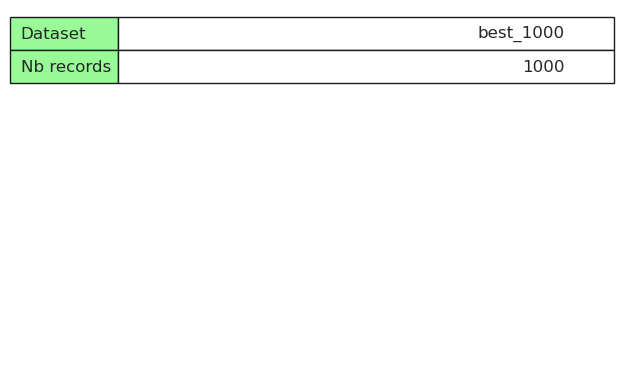

In [846]:
metadata= [["Dataset", dataset],
          ["Nb records", data.shape[0]]]


fig, ax =plt.subplots()
ax.set_axis_off() 
tbl = ax.table(cellText = [ r[1:] for r in metadata],
         rowLabels = [r[0] for r in metadata],
         rowColours = ["palegreen"] * len(metadata),
        loc="upper left")
tbl.scale(1,2)
pdf.savefig( bbox_inches='tight')

# Geocode

In [847]:
try: 
    no_res_timing = pd.read_pickle(f"output/geocoding/no_res_timing_{dataset}.pkl")
except FileNotFoundError: 
    no_res_timing = pd.DataFrame(columns =["address", "geocoder", "duration"] )

In [848]:
import datetime
#no_res_timing ={}
def geocode_and_timeit(geocoder, addr):
    global no_res_timing
    start = datetime.datetime.now()
    res = geocoder(addr)
    if res:
        res.raw.update({"duration": datetime.datetime.now()-start})
    else: 
        geocoder_name = list(filter(lambda y: y[1] == geocoder.__self__ , [(x, geocoders[x]) for x in geocoders]))[0][0]
        
        no_res_timing = pd.concat([no_res_timing, pd.DataFrame([{"address":  addr,
                                              "duration": (datetime.datetime.now()-start).total_seconds(), 
                                              "geocoder": geocoder_name}])])
    return res

In [849]:
geocoded_data_r = [] #gpd.GeoDataFrame()
coders=["nominatim_wrapper", "nominatim", "here", "bing", "mapbox", "tomtom", "google", "bestaddress", 
        "ngi_pelias"]
coders=["nominatim_wrapper", "nominatim", "here", "bing", "google", "tomtom", "ngi_pelias"]

# coders=[ "bing", "google", "here", "tomtom", "nominatim", "nominatim_wrapper", "pelias", "ngi_pelias"]
coders=[ "bing", "google", "here", "tomtom", "nominatim", "pelias", "photon"]

coders=["here", "bing", "tomtom", "google", "nominatim_wrapper", "nominatim"]
# coders=["here", "bing", "tomtom", "google", "nominatim_loc"]
# coders =["nominatim_wrapper", "nominatim_loc", "pelias", "bestaddress", "pelias_plus"]

# from_file = ["nominatim", "here", "bing", "tomtom", "google"]
from_file = coders

# coders =["pelias", "pelias_struct", "ngi_pelias_basic", "ngi_pelias_simple", "ngi_pelias"]
# from_file=["pelias", "pelias_struct", ] 
# from_file = coders

# coders =["photon"]#, "pelias", "pelias_struct"]#, "ngi_pelias_basic", "ngi_pelias_simple"]
# from_file=[] 


delay={"mapbox":0.5, "nominatim_wrapper":0.01,  "nominatim":0.01, "lpost_bestaddress": 0.01, "google":0.5, "tomtom": 0.4,
      "ngi_pelias": 0.02, "pelias": 0.02 
      }



for coder in coders: #geocoders:
    print(coder)
    
    if coder in from_file:
        print("Load from local file...")
        g_data = pd.read_pickle(f"output/geocoding/geocoded_data/geocoded_{dataset}_{coder}.pkl")
    else: 
        
        # Erase no-res timing for this coder for any previous run
        no_res_timing = no_res_timing[no_res_timing.geocoder != coder]
        
        g = geocoders[coder]
        g.geocode_timeit = lambda x: geocode_and_timeit(g.geocode, x)
        geocode = RateLimiter(g.geocode_timeit, min_delay_seconds=delay[coder] if coder in delay else 0.2)

        if coder in ["bestaddress", "ngi_pelias", 'ngi_pelias_basic', 'ngi_pelias_simple']: # structured addresses
            g_data = data.assign(location=data[["street", "housenumber", "postcode", "city"]].apply(dict, axis=1).progress_apply(geocode)).assign(geocoder=coder)
        elif coder in ["pelias_struct"]: # structured pelias
            g_data = data.assign(location=data.assign(address = data["street"]+", "+data["housenumber"]).\
                          rename(columns={"postcode": "postalcode", "city": "locality"})[["address", "postalcode", "locality"]].apply(dict, axis=1).progress_apply(geocode)).assign(geocoder=coder)

        else: 
            g_data = data.assign(location=(data['address'].str.replace("/", "%2F") if coder=="tomtom" else data['address']).progress_apply(geocode)).assign(geocoder=coder)
#             g_data = data.assign(location=data['address'].progress_apply(geocode)).assign(geocoder=coder)
        g_data.to_pickle(f"output/geocoding/geocoded_data/geocoded_{dataset}_{coder}.pkl")
    
    geocoded_data_r.append(g_data)
    display(g_data)
    

here
Load from local file...


reference_key                    street housenumber postcode  \
0                0      Koningin Fabiolalaan           1     1654   
1                1     Rue du Moulin de Nimy           7     7020   
2                2      Steenweg op Wezemaal         143     3110   
3                3                Merestraat          35     3130   
4                4              Van Eycklaan          23     9840   
..             ...                       ...         ...      ...   
995            995       Koningin Astridlaan     61_0054     8450   
996            996  Rue Jean Hubert Tillmans          21     4620   
997            997          Rue Hector-Denis          49     4031   
998            998               Grotestraat           5     8420   
999            999               Heidestraat          12     1742   

             city                                            address  \
0         Beersel    Koningin Fabiolalaan, 1, 1654 Beersel, Belgique   
1            Mons      Rue du Moulin de Nimy, 7, 7020 Mons, Belgique   
2       Rotselaar  Steenweg op Wezemaal, 143, 3110 Rotselaar, Bel...   
3    Begijnendijk        Merestraat, 35, 3130 Begijnendijk, Belgique   
4        De Pinte          Van Eycklaan, 23, 9840 De Pinte, Belgique   
..            ...                                                ...   
995       Bredene  Koningin Astridlaan, 61_0054, 8450 Bredene, Be...   
996        Fléron  Rue Jean Hubert Tillmans, 21, 4620 Fléron, Bel...   
997         Liège         Rue Hector-Denis, 49, 4031 Liège, Belgique   
998       De Haan             Grotestraat, 5, 8420 De Haan, Belgique   
999        Ternat             Heidestraat, 12, 1742 Ternat, Belgique   

                                              location geocoder  
0    (Koningin Fabiolalaan 1, 1654 Beersel, België,...     here  
1    (Rue du Moulin de Nimy 5, 7020 Mons, Belgique,...     here  
2    (Steenweg op Wezemaal 143, 3110 Rotselaar, Bel...     here  
3    (Merestraat 35, 3130 Begijnendijk, België, Beg...     here  
4    (Van Eycklaan 23, 9840 De Pinte, België, De Pi...     here  
..                                                 ...      ...  
995  (Koningin Astridlaan 61, 8450 Bredene, België,...     here  
996  (Rue Jean-Hubert Tillmans 21, 4620 Fléron, Bel...     here  
997  (Rue Hector Denis 49, 4031 Liège, Belgique, Li...     here  
998  (Grotestraat 5, 8420 De Haan, België, De Haan,...     here  
999  (Heidestraat 12, 1742 Ternat, België, Ternat, ...     here  

[1000 rows x 8 columns]

bing
Load from local file...


reference_key                    street housenumber postcode  \
0                0      Koningin Fabiolalaan           1     1654   
1                1     Rue du Moulin de Nimy           7     7020   
2                2      Steenweg op Wezemaal         143     3110   
3                3                Merestraat          35     3130   
4                4              Van Eycklaan          23     9840   
..             ...                       ...         ...      ...   
995            995       Koningin Astridlaan     61_0054     8450   
996            996  Rue Jean Hubert Tillmans          21     4620   
997            997          Rue Hector-Denis          49     4031   
998            998               Grotestraat           5     8420   
999            999               Heidestraat          12     1742   

             city                                            address  \
0         Beersel    Koningin Fabiolalaan, 1, 1654 Beersel, Belgique   
1            Mons      Rue du Moulin de Nimy, 7, 7020 Mons, Belgique   
2       Rotselaar  Steenweg op Wezemaal, 143, 3110 Rotselaar, Bel...   
3    Begijnendijk        Merestraat, 35, 3130 Begijnendijk, Belgique   
4        De Pinte          Van Eycklaan, 23, 9840 De Pinte, Belgique   
..            ...                                                ...   
995       Bredene  Koningin Astridlaan, 61_0054, 8450 Bredene, Be...   
996        Fléron  Rue Jean Hubert Tillmans, 21, 4620 Fléron, Bel...   
997         Liège         Rue Hector-Denis, 49, 4031 Liège, Belgique   
998       De Haan             Grotestraat, 5, 8420 De Haan, Belgique   
999        Ternat             Heidestraat, 12, 1742 Ternat, Belgique   

                                              location geocoder  
0    (Koningin Fabiolalaan 1, Beersel, Flemish Regi...     bing  
1    (Rue du Moulin de Nimy 7, Mons, Walloon Region...     bing  
2    (Steenweg op Wezemaal 143, Rotselaar, Flemish ...     bing  
3    (Merestraat 35, Begijnendijk, Flemish Region 3...     bing  
4    (Van Eycklaan 23, De Pinte, Flemish Region 984...     bing  
..                                                 ...      ...  
995  (Koningin Astridlaan 61, Bredene, Flemish Regi...     bing  
996  (Rue Jean-Hubert Tillmans 21, Fléron, Walloon ...     bing  
997  (Rue Hector Denis 49, Liège, Walloon Region 40...     bing  
998  (Grotestraat 5, De Haan, Flemish Region 8420, ...     bing  
999  (Heidestraat 12, Ternat, Flemish Region 1742, ...     bing  

[1000 rows x 8 columns]

tomtom
Load from local file...


reference_key                    street housenumber postcode  \
0                0      Koningin Fabiolalaan           1     1654   
1                1     Rue du Moulin de Nimy           7     7020   
2                2      Steenweg op Wezemaal         143     3110   
3                3                Merestraat          35     3130   
4                4              Van Eycklaan          23     9840   
..             ...                       ...         ...      ...   
995            995       Koningin Astridlaan     61_0054     8450   
996            996  Rue Jean Hubert Tillmans          21     4620   
997            997          Rue Hector-Denis          49     4031   
998            998               Grotestraat           5     8420   
999            999               Heidestraat          12     1742   

             city                                            address  \
0         Beersel    Koningin Fabiolalaan, 1, 1654 Beersel, Belgique   
1            Mons      Rue du Moulin de Nimy, 7, 7020 Mons, Belgique   
2       Rotselaar  Steenweg op Wezemaal, 143, 3110 Rotselaar, Bel...   
3    Begijnendijk        Merestraat, 35, 3130 Begijnendijk, Belgique   
4        De Pinte          Van Eycklaan, 23, 9840 De Pinte, Belgique   
..            ...                                                ...   
995       Bredene  Koningin Astridlaan, 61_0054, 8450 Bredene, Be...   
996        Fléron  Rue Jean Hubert Tillmans, 21, 4620 Fléron, Bel...   
997         Liège         Rue Hector-Denis, 49, 4031 Liège, Belgique   
998       De Haan             Grotestraat, 5, 8420 De Haan, Belgique   
999        Ternat             Heidestraat, 12, 1742 Ternat, Belgique   

                                              location geocoder  
0    (Koningin Fabiolalaan 1, 1654 Beersel, (50.745...   tomtom  
1    (Rue du Moulin de Nimy 7, 7020 Mons, (50.47729...   tomtom  
2    (Steenweg op Wezemaal 143, 3110 Rotselaar, (50...   tomtom  
3    (Merestraat 35, 3130 Begijnendijk, (51.02123, ...   tomtom  
4    (Van Eycklaan 23, 9840 De Pinte, (50.99371, 3....   tomtom  
..                                                 ...      ...  
995  (Koningin Astridlaan 61, 8450 Bredene, (51.251...   tomtom  
996  (Rue Jean-Hubert Tillmans 21, 4620 Fléron, (50...   tomtom  
997  (Rue Hector Denis 49, 4031 Liège, (50.61185, 5...   tomtom  
998    (Grotestraat 5, 8420 De Haan, (51.2705, 3.035))   tomtom  
999  (Heidestraat 12, 1742 Ternat, (50.87275, 4.147...   tomtom  

[1000 rows x 8 columns]

google
Load from local file...


reference_key                    street housenumber postcode  \
0                0      Koningin Fabiolalaan           1     1654   
1                1     Rue du Moulin de Nimy           7     7020   
2                2      Steenweg op Wezemaal         143     3110   
3                3                Merestraat          35     3130   
4                4              Van Eycklaan          23     9840   
..             ...                       ...         ...      ...   
995            995       Koningin Astridlaan     61_0054     8450   
996            996  Rue Jean Hubert Tillmans          21     4620   
997            997          Rue Hector-Denis          49     4031   
998            998               Grotestraat           5     8420   
999            999               Heidestraat          12     1742   

             city                                            address  \
0         Beersel    Koningin Fabiolalaan, 1, 1654 Beersel, Belgique   
1            Mons      Rue du Moulin de Nimy, 7, 7020 Mons, Belgique   
2       Rotselaar  Steenweg op Wezemaal, 143, 3110 Rotselaar, Bel...   
3    Begijnendijk        Merestraat, 35, 3130 Begijnendijk, Belgique   
4        De Pinte          Van Eycklaan, 23, 9840 De Pinte, Belgique   
..            ...                                                ...   
995       Bredene  Koningin Astridlaan, 61_0054, 8450 Bredene, Be...   
996        Fléron  Rue Jean Hubert Tillmans, 21, 4620 Fléron, Bel...   
997         Liège         Rue Hector-Denis, 49, 4031 Liège, Belgique   
998       De Haan             Grotestraat, 5, 8420 De Haan, Belgique   
999        Ternat             Heidestraat, 12, 1742 Ternat, Belgique   

                                              location geocoder  
0    (Kon. Fabiolalaan 1, 1654 Beersel, Belgium, (5...   google  
1    (Rue du Moulin de Nimy 7, 7020 Mons, Belgium, ...   google  
2    (Steenweg op Wezemaal 143, 3110 Rotselaar, Bel...   google  
3    (Merestraat 35, 3130 Begijnendijk, Belgium, (5...   google  
4    (Van Eycklaan 23, 9840 De Pinte, Belgium, (50....   google  
..                                                 ...      ...  
995  (Kon. Astridlaan 61, 8450 Bredene, Belgium, (5...   google  
996  (Rue J. - H Tillmans 21, 4620 Fléron, Belgium,...   google  
997  (Rue Hector Denis 49, 4031 Liège, Belgium, (50...   google  
998  (Grotestraat 5, 8420 De Haan, Belgium, (51.270...   google  
999  (Heidestraat 12, 1742 Ternat, Belgium, (50.872...   google  

[1000 rows x 8 columns]

nominatim_wrapper
Load from local file...


reference_key                    street housenumber postcode  \
0                0      Koningin Fabiolalaan           1     1654   
1                1     Rue du Moulin de Nimy           7     7020   
2                2      Steenweg op Wezemaal         143     3110   
3                3                Merestraat          35     3130   
4                4              Van Eycklaan          23     9840   
..             ...                       ...         ...      ...   
995            995       Koningin Astridlaan     61_0054     8450   
996            996  Rue Jean Hubert Tillmans          21     4620   
997            997          Rue Hector-Denis          49     4031   
998            998               Grotestraat           5     8420   
999            999               Heidestraat          12     1742   

             city                                            address  \
0         Beersel    Koningin Fabiolalaan, 1, 1654 Beersel, Belgique   
1            Mons      Rue du Moulin de Nimy, 7, 7020 Mons, Belgique   
2       Rotselaar  Steenweg op Wezemaal, 143, 3110 Rotselaar, Bel...   
3    Begijnendijk        Merestraat, 35, 3130 Begijnendijk, Belgique   
4        De Pinte          Van Eycklaan, 23, 9840 De Pinte, Belgique   
..            ...                                                ...   
995       Bredene  Koningin Astridlaan, 61_0054, 8450 Bredene, Be...   
996        Fléron  Rue Jean Hubert Tillmans, 21, 4620 Fléron, Bel...   
997         Liège         Rue Hector-Denis, 49, 4031 Liège, Belgique   
998       De Haan             Grotestraat, 5, 8420 De Haan, Belgique   
999        Ternat             Heidestraat, 12, 1742 Ternat, Belgique   

                                              location           geocoder  
0    (1, Koningin Fabiolalaan, Oud Dorp, Huizingen,...  nominatim_wrapper  
1    (Rue du Moulin de Nimy, Nimy, Mons, Hainaut, W...  nominatim_wrapper  
2    (143, Steenweg op Wezemaal, Rotselaar, Leuven,...  nominatim_wrapper  
3    (35, Merestraat, Begijnendijk, Leuven, Vlaams-...  nominatim_wrapper  
4    (Van Eycklaan, De Pinte, Gent, Oost-Vlaanderen...  nominatim_wrapper  
..                                                 ...                ...  
995  (Koningin Astridlaan, Bredene-Bad, Bredene, Oo...  nominatim_wrapper  
996  (21, Rue Jean-Hubert Tillmans, Cité du Fort, R...  nominatim_wrapper  
997  (49, Rue Hector Denis, Angleur, Liège, Walloni...  nominatim_wrapper  
998  (5, Grotestraat, Concessiewijk, De Haan, Klems...  nominatim_wrapper  
999  (Heidestraat, Sint-Katherina-Lombeek, Ternat, ...  nominatim_wrapper  

[1000 rows x 8 columns]

nominatim
Load from local file...


reference_key                    street housenumber postcode  \
0                0      Koningin Fabiolalaan           1     1654   
1                1     Rue du Moulin de Nimy           7     7020   
2                2      Steenweg op Wezemaal         143     3110   
3                3                Merestraat          35     3130   
4                4              Van Eycklaan          23     9840   
..             ...                       ...         ...      ...   
995            995       Koningin Astridlaan     61_0054     8450   
996            996  Rue Jean Hubert Tillmans          21     4620   
997            997          Rue Hector-Denis          49     4031   
998            998               Grotestraat           5     8420   
999            999               Heidestraat          12     1742   

             city                                            address  \
0         Beersel    Koningin Fabiolalaan, 1, 1654 Beersel, Belgique   
1            Mons      Rue du Moulin de Nimy, 7, 7020 Mons, Belgique   
2       Rotselaar  Steenweg op Wezemaal, 143, 3110 Rotselaar, Bel...   
3    Begijnendijk        Merestraat, 35, 3130 Begijnendijk, Belgique   
4        De Pinte          Van Eycklaan, 23, 9840 De Pinte, Belgique   
..            ...                                                ...   
995       Bredene  Koningin Astridlaan, 61_0054, 8450 Bredene, Be...   
996        Fléron  Rue Jean Hubert Tillmans, 21, 4620 Fléron, Bel...   
997         Liège         Rue Hector-Denis, 49, 4031 Liège, Belgique   
998       De Haan             Grotestraat, 5, 8420 De Haan, Belgique   
999        Ternat             Heidestraat, 12, 1742 Ternat, Belgique   

                                              location   geocoder  
0    (1, Koningin Fabiolalaan, Oud Dorp, Huizingen,...  nominatim  
1    (Rue du Moulin de Nimy, Nimy, Mons, Hainaut, W...  nominatim  
2    (143, Steenweg op Wezemaal, Rotselaar, Leuven,...  nominatim  
3    (35, Merestraat, Begijnendijk, Leuven, Vlaams-...  nominatim  
4    (Van Eycklaan, De Pinte, Gent, Oost-Vlaanderen...  nominatim  
..                                                 ...        ...  
995  (Koningin Astridlaan, Bredene-Bad, Bredene, Oo...  nominatim  
996  (21, Rue Jean-Hubert Tillmans, Cité du Fort, R...  nominatim  
997  (49, Rue Hector Denis, Angleur, Liège, Walloni...  nominatim  
998  (5, Grotestraat, Concessiewijk, De Haan, Klems...  nominatim  
999  (Heidestraat, Sint-Katherina-Lombeek, Ternat, ...  nominatim  

[1000 rows x 8 columns]

## Gather results

In [850]:
geocoded_data = pd.concat(geocoded_data_r).reset_index(drop=True)
geocoded_data = geocoded_data[geocoded_data.location.notnull()]
geocoded_data

reference_key                    street housenumber postcode  \
0                 0      Koningin Fabiolalaan           1     1654   
1                 1     Rue du Moulin de Nimy           7     7020   
2                 2      Steenweg op Wezemaal         143     3110   
3                 3                Merestraat          35     3130   
4                 4              Van Eycklaan          23     9840   
...             ...                       ...         ...      ...   
5995            995       Koningin Astridlaan     61_0054     8450   
5996            996  Rue Jean Hubert Tillmans          21     4620   
5997            997          Rue Hector-Denis          49     4031   
5998            998               Grotestraat           5     8420   
5999            999               Heidestraat          12     1742   

              city                                            address  \
0          Beersel    Koningin Fabiolalaan, 1, 1654 Beersel, Belgique   
1             Mons      Rue du Moulin de Nimy, 7, 7020 Mons, Belgique   
2        Rotselaar  Steenweg op Wezemaal, 143, 3110 Rotselaar, Bel...   
3     Begijnendijk        Merestraat, 35, 3130 Begijnendijk, Belgique   
4         De Pinte          Van Eycklaan, 23, 9840 De Pinte, Belgique   
...            ...                                                ...   
5995       Bredene  Koningin Astridlaan, 61_0054, 8450 Bredene, Be...   
5996        Fléron  Rue Jean Hubert Tillmans, 21, 4620 Fléron, Bel...   
5997         Liège         Rue Hector-Denis, 49, 4031 Liège, Belgique   
5998       De Haan             Grotestraat, 5, 8420 De Haan, Belgique   
5999        Ternat             Heidestraat, 12, 1742 Ternat, Belgique   

                                               location   geocoder  
0     (Koningin Fabiolalaan 1, 1654 Beersel, België,...       here  
1     (Rue du Moulin de Nimy 5, 7020 Mons, Belgique,...       here  
2     (Steenweg op Wezemaal 143, 3110 Rotselaar, Bel...       here  
3     (Merestraat 35, 3130 Begijnendijk, België, Beg...       here  
4     (Van Eycklaan 23, 9840 De Pinte, België, De Pi...       here  
...                                                 ...        ...  
5995  (Koningin Astridlaan, Bredene-Bad, Bredene, Oo...  nominatim  
5996  (21, Rue Jean-Hubert Tillmans, Cité du Fort, R...  nominatim  
5997  (49, Rue Hector Denis, Angleur, Liège, Walloni...  nominatim  
5998  (5, Grotestraat, Concessiewijk, De Haan, Klems...  nominatim  
5999  (Heidestraat, Sint-Katherina-Lombeek, Ternat, ...  nominatim  

[5969 rows x 8 columns]

In [851]:
# geocoded_data["geocoder"]=geocoded_data["geocoder"].replace("ngi_pelias", "pelias_plus")
# coders.append("pelias_plus")
# coders.remove("ngi_pelias")

In [852]:
geocoded_data.geocoder.value_counts()

here                 1000
bing                 1000
tomtom               1000
google               1000
nominatim_wrapper     995
nominatim             974
Name: geocoder, dtype: int64

# Duration

In [853]:
geocoded_data["duration"] = geocoded_data["location"].apply(lambda loc: loc.raw["duration"] if loc and "duration" in loc.raw else None).dt.total_seconds()

In [854]:
geocoded_data.groupby("geocoder").address.count().sum()#["duration"]


5969

In [855]:
no_res_timing.to_pickle(f"output/geocoding/no_res_timing_{dataset}.pkl")

In [856]:
geocoded_data_duration = pd.concat([geocoded_data.assign(with_result=True), 
                                    no_res_timing[no_res_timing.geocoder.isin(coders)].assign(with_result=False)])
geocoded_data_duration = geocoded_data_duration.reset_index()[["address", "geocoder", "duration", "with_result"]]
geocoded_data_duration["address"] = geocoded_data_duration["address"].astype(str)

In [857]:
geocoded_data_duration.sort_values("duration")

address           geocoder  \
5980   Personaathoflaan, 14, 1700 Dilbeek, Belgique          nominatim   
5972       Bois de Seurus, 58, 6531 Thuin, Belgique          nominatim   
5272            Rue Guiot, 5, 5500 Dinant, Belgique          nominatim   
5948        Vinkenslag, 7, 2200 Herentals, Belgique          nominatim   
5946            Voortweg, 2, 3950 Bocholt, Belgique          nominatim   
...                                             ...                ...   
5997    Koolmeesstraat, 23, 2530 Boechout, Belgique  nominatim_wrapper   
5995                  Sas, 3, 3150 Haacht, Belgique  nominatim_wrapper   
1197               Plaats, 59, 1547 Bever, Belgique               bing   
1595  Rue des Ruelles, 12, 6150 Anderlues, Belgique               bing   
4893            Keistraat, 9, 3300 Tienen, Belgique  nominatim_wrapper   

      duration  with_result  
5980  0.003697        False  
5972  0.004041        False  
5272  0.008909         True  
5948  0.009352         True  
5946  0.009352         True  
...        ...          ...  
5997  1.213273        False  
5995  1.290363        False  
1197  1.309707         True  
1595  1.333908         True  
4893  1.435698         True  

[6000 rows x 4 columns]

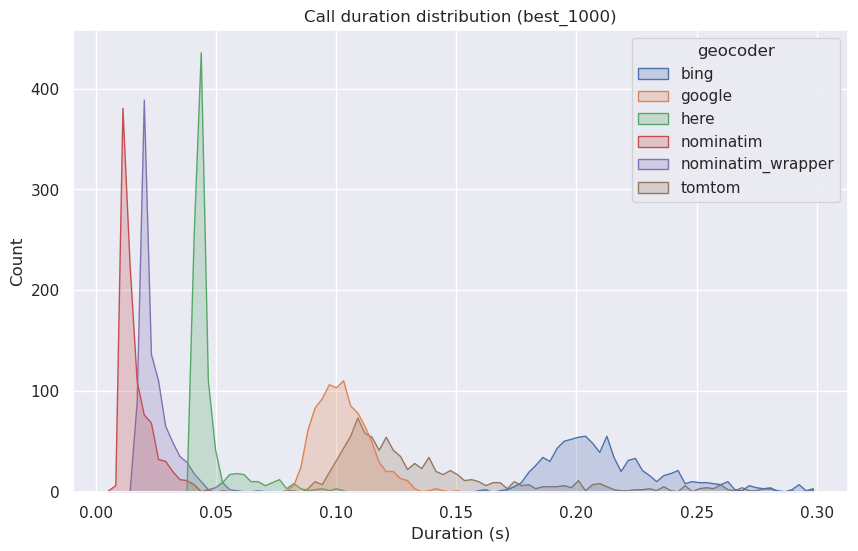

In [858]:
plt.figure(figsize=(10,6))
sbn.histplot(geocoded_data_duration[geocoded_data_duration.duration<0.3].sort_values("geocoder"), 
             x="duration", hue="geocoder", element="poly",
            bins=100).set(title=f'Call duration distribution ({dataset})', xlabel="Duration (s)")

pdf.savefig(bbox_inches='tight')

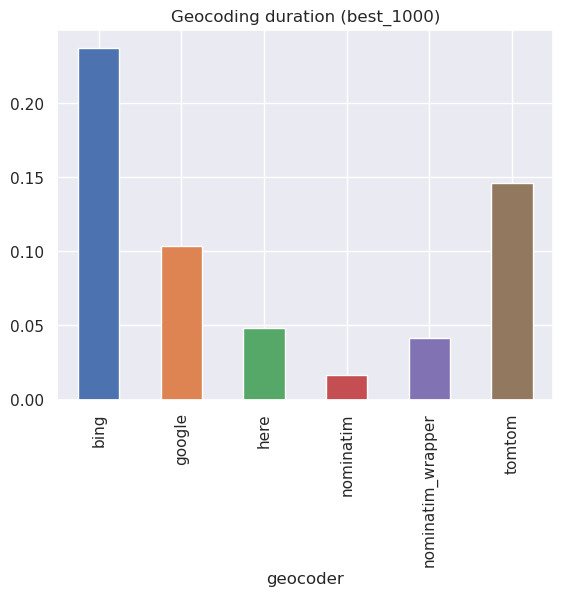

In [859]:
colors = [f"C{i}" for i in range(geocoded_data.geocoder.nunique())]

geocoded_data_duration.groupby("geocoder").duration.mean().plot.bar(color=colors, title=f"Geocoding duration ({dataset})")
plt.savefig(f'{fig_path}/geocoding_speed.png', dpi=150,  bbox_inches='tight')
pdf.savefig(bbox_inches='tight')

<Axes: title={'center': 'Geocoding duration (best_1000)'}, xlabel='geocoder'>

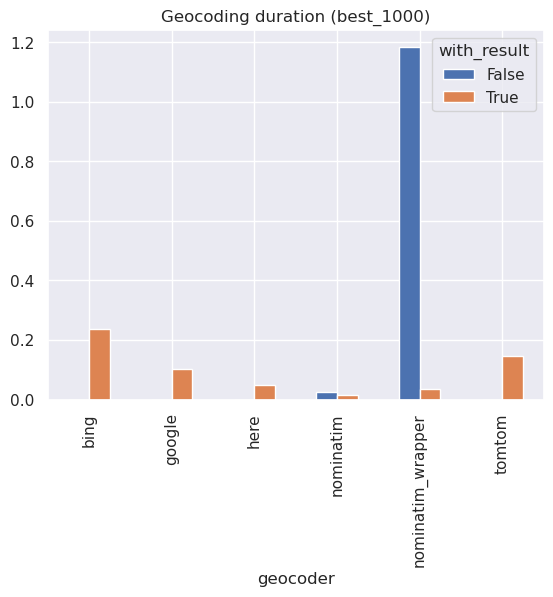

In [860]:
geocoded_data_duration.groupby(["geocoder", "with_result"]).duration.mean().unstack().plot.bar(title=f"Geocoding duration ({dataset})")

In [861]:
# geocoded_data_duration[geocoded_data_duration.geocoder=="tomtom"]

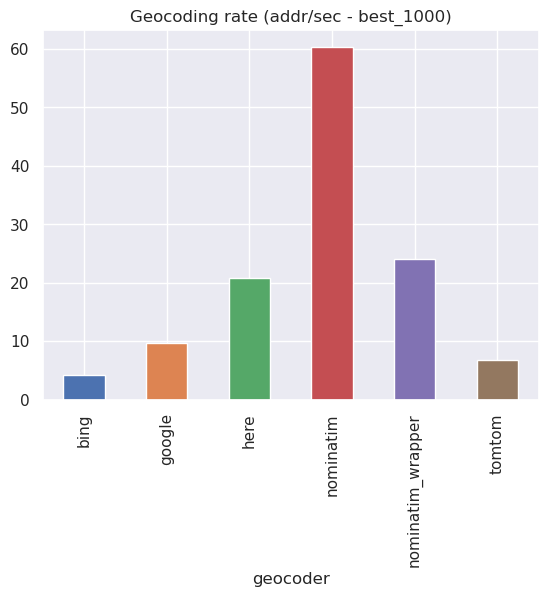

In [862]:
colors = [f"C{i}" for i in range(geocoded_data.geocoder.nunique())]

(1/geocoded_data_duration.groupby("geocoder").duration.mean()).plot.bar(color=colors, title=f"Geocoding rate (addr/sec - {dataset})")
# plt.savefig(f'{fig_path}/geocoding_speed_rate.png', dpi=150,  bbox_inches='tight')
pdf.savefig(bbox_inches='tight')

# Matching rate

## Matching rate

In [863]:
data

reference_key                    street housenumber postcode  \
0                0      Koningin Fabiolalaan           1     1654   
1                1     Rue du Moulin de Nimy           7     7020   
2                2      Steenweg op Wezemaal         143     3110   
3                3                Merestraat          35     3130   
4                4              Van Eycklaan          23     9840   
..             ...                       ...         ...      ...   
995            995       Koningin Astridlaan     61_0054     8450   
996            996  Rue Jean Hubert Tillmans          21     4620   
997            997          Rue Hector-Denis          49     4031   
998            998               Grotestraat           5     8420   
999            999               Heidestraat          12     1742   

             city                                            address  
0         Beersel    Koningin Fabiolalaan, 1, 1654 Beersel, Belgique  
1            Mons      Rue du Moulin de Nimy, 7, 7020 Mons, Belgique  
2       Rotselaar  Steenweg op Wezemaal, 143, 3110 Rotselaar, Bel...  
3    Begijnendijk        Merestraat, 35, 3130 Begijnendijk, Belgique  
4        De Pinte          Van Eycklaan, 23, 9840 De Pinte, Belgique  
..            ...                                                ...  
995       Bredene  Koningin Astridlaan, 61_0054, 8450 Bredene, Be...  
996        Fléron  Rue Jean Hubert Tillmans, 21, 4620 Fléron, Bel...  
997         Liège         Rue Hector-Denis, 49, 4031 Liège, Belgique  
998       De Haan             Grotestraat, 5, 8420 De Haan, Belgique  
999        Ternat             Heidestraat, 12, 1742 Ternat, Belgique  

[1000 rows x 6 columns]

In [864]:
mr = (geocoded_data.groupby("geocoder").address.count()/ data.shape[0])

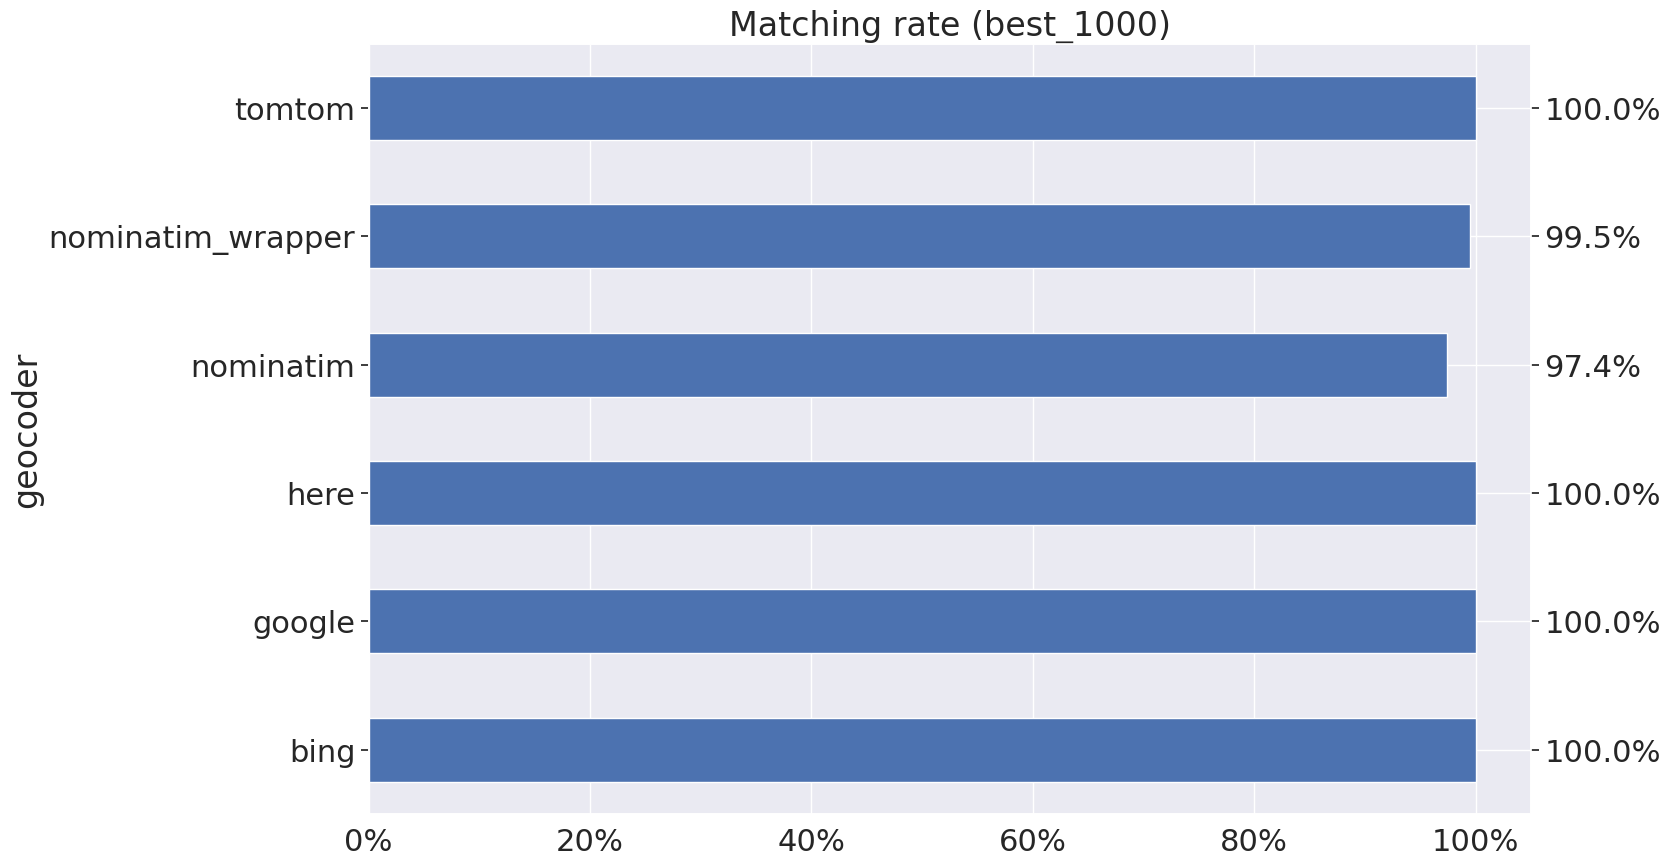

In [865]:
def show_values_on_hbars(ax, values):
    
    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim())
    ax2.set_yticks(ax.get_yticks())
    ax2.set_yticklabels(values.apply("{:.1%}".format))#mr_prec_plot.get_yticklabels())
    # ax2.xaxis.set_major_formatter('')
    ax2.grid(axis='y')   
    
    


plt.figure(figsize=(15,10))
sbn.set(font_scale=2)

mr_plot=mr.rename("matching rate").plot.barh(title=f"Matching rate ({dataset})")

show_values_on_hbars(mr_plot, mr)


mr_plot.xaxis.set_major_formatter('{x:.0%}')


pdf.savefig(bbox_inches='tight')

sbn.set(font_scale=1)



In [866]:
# geocoded_data.groupby("address").geocoder.count().value_counts().sort_index(ascending=False).plot.bar(title="Number of success per address")

## Extract precision

In [867]:
geocoded_data["precision"] = geocoded_data.apply(get_precision, axis=1)

In [868]:
geocoded_data[geocoded_data.precision.str.contains("UNK")][["geocoder" , "precision"]].value_counts()#drop_duplicates()

geocoder   precision           
nominatim  [UNKNOWN - boundary]    1
dtype: int64

In [869]:
geocoded_data[geocoded_data.precision.str.contains("UNK")]

reference_key             street housenumber postcode   city  \
5071             71  Vlamertingestraat          20     8908  Ieper   

                                          address  \
5071  Vlamertingestraat, 20, 8908 Ieper, Belgique   

                                               location   geocoder  duration  \
5071  (Vlamertinge, Ieper, West-Vlaanderen, Vlaander...  nominatim  0.037154   

                 precision  
5071  [UNKNOWN - boundary]

In [870]:
geocoded_data["precision"] = geocoded_data.precision.replace("^\[UNKNOWN.*\]", "[UNKNOWN]", regex=True)

## Precision

In [871]:
mr

geocoder
bing                 1.000
google               1.000
here                 1.000
nominatim            0.974
nominatim_wrapper    0.995
tomtom               1.000
Name: address, dtype: float64

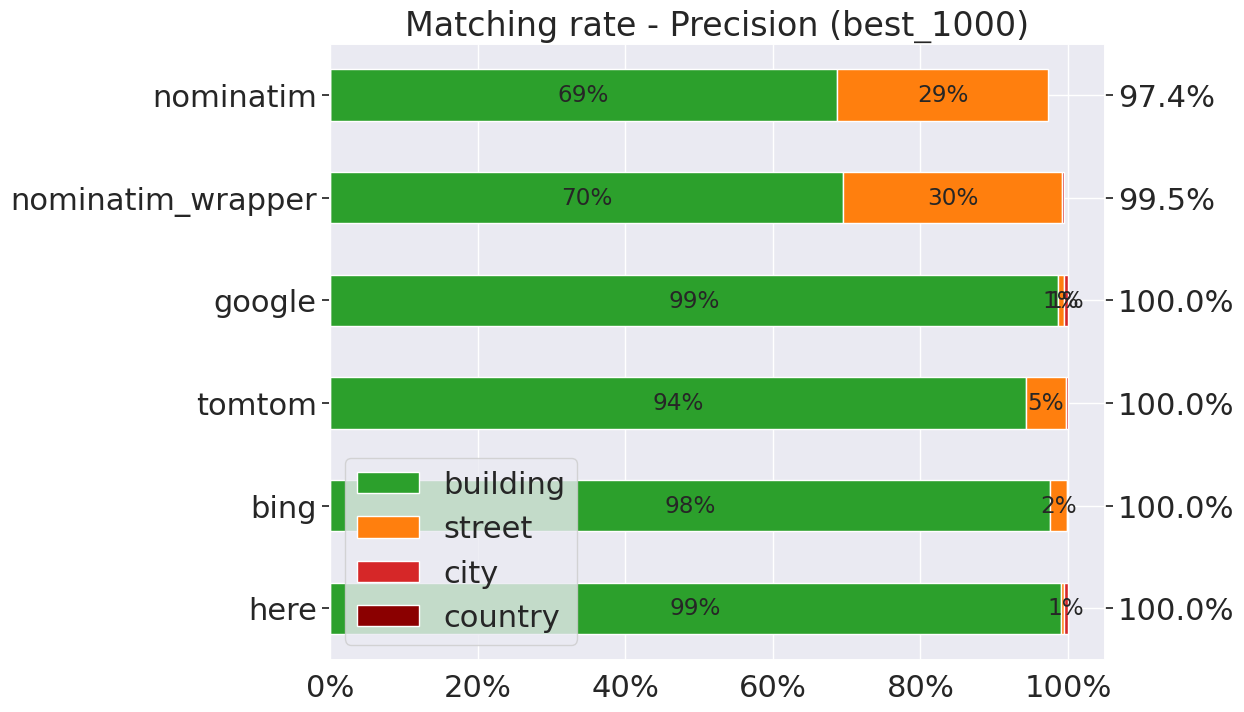

In [872]:
sbn.set(font_scale=2)
mr_prec = geocoded_data.groupby(["geocoder", "precision"]).address.count().unstack()
mr_prec = mr_prec/data.shape[0]
mr_prec = mr_prec.reindex(["building", "street", "city", "country"], axis=1).reindex(coders, axis=0) # , "[UNKNOWN]"

mr_prec_plot= mr_prec.plot.barh(stacked=True, 
                                figsize=(10,8), 
                                title=f"Matching rate - Precision ({dataset})", 
                                color=["tab:green", "tab:orange", "tab:red", "darkred" , "tab:grey"])
mr_prec_plot.xaxis.set_major_formatter('{x:.0%}')

mr_prec_plot.set_ylabel(None)

plt.legend(loc='lower left')

show_values_on_hbars(mr_prec_plot, mr.reindex(coders))

for bars in mr_prec_plot.containers:
    mr_prec_plot.bar_label(bars, label_type="center", fmt=lambda x: "{0:.0%}".format(x) if x >0.005 else "", fontproperties={"size":"x-small"})

    
plt.savefig(f'{fig_path}/matching_rate_{dataset}.png', dpi=150,  bbox_inches='tight')
pdf.savefig(bbox_inches='tight')

sbn.set(font_scale=1)


In [386]:
mr_prec

precision  building  street   city  country
geocoder                                   
bing          0.964   0.034  0.002      NaN
google        0.867   0.126  0.007      NaN
here          0.973   0.024  0.003      NaN
tomtom        0.895   0.104  0.001      NaN
nominatim     0.632   0.237    NaN      NaN
pelias        0.613   0.070  0.308    0.006
photon        0.733   0.239  0.025      NaN

In [387]:
# no builing MR (for Nominatim):
# best : 31.6+0.4 = 32 %
# kbo : 24+1 = 25 %
# resto : 13.1 + 4.5 = 17.5 
with pd.option_context('display.float_format', '{:0.1%}'.format):
    display(mr_prec.fillna(""))


precision  building  street  city country
geocoder                                 
bing          96.4%    3.4%  0.2%        
google        86.7%   12.6%  0.7%        
here          97.3%    2.4%  0.3%        
tomtom        89.5%   10.4%  0.1%        
nominatim     63.2%   23.7%              
pelias        61.3%    7.0% 30.8%    0.6%
photon        73.3%   23.9%  2.5%

In [388]:
# geocoded_data

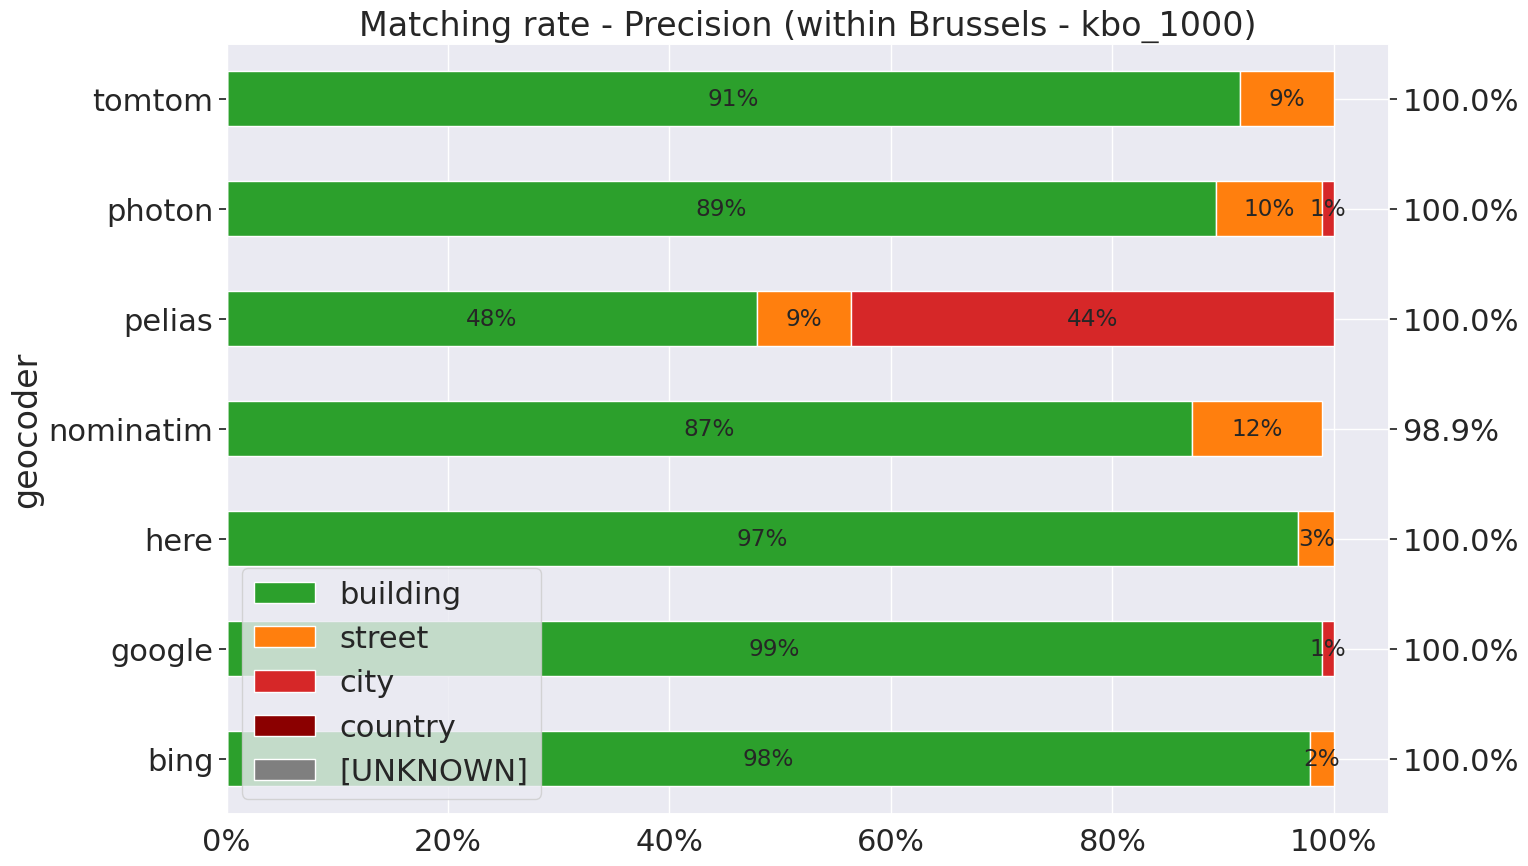

In [389]:
addr_in_bru = geocoded_data[geocoded_data.postcode.astype(int).between(1000, 1299)].address
geocoded_data_bru = geocoded_data[geocoded_data.address.isin(addr_in_bru)] 


sbn.set(font_scale=2)
mr_prec = geocoded_data_bru.groupby(["geocoder", "precision"]).address.count().unstack()
mr_prec = mr_prec/geocoded_data_bru.address.nunique()
mr_prec = mr_prec.reindex(["building", "street", "city", "country", "[UNKNOWN]"], axis=1)

mr_prec_plot= mr_prec.plot.barh(stacked=True, 
                                figsize=(15,10), 
                                title=f"Matching rate - Precision (within Brussels - {dataset})",
                                color=["tab:green", "tab:orange", "tab:red", "darkred" , "tab:grey"])
mr_prec_plot.xaxis.set_major_formatter('{x:.0%}')


plt.legend(loc='lower left')



mr_bru = (geocoded_data_bru.groupby("geocoder").address.count()/ geocoded_data_bru.address.nunique())

show_values_on_hbars(mr_prec_plot, mr_bru)
for bars in mr_prec_plot.containers:
    mr_prec_plot.bar_label(bars, label_type="center", fmt=lambda x: "{0:.0%}".format(x) if x >0 else "", fontproperties={"size":"x-small"})


pdf.savefig(bbox_inches='tight')

sbn.set(font_scale=1)

# Distance to median statistics

## Extract location

In [390]:
lat = geocoded_data["location"].apply(lambda loc: loc.point.latitude if loc and loc.point.latitude >0 else None)
lng =  geocoded_data["location"].apply(lambda loc: loc.point.longitude if loc else None)
geocoded_data["point"] = np.where(lat.notnull(), gpd.points_from_xy(lng, lat), pd.NA)

In [391]:
geocoded_data[geocoded_data.point.isnull()]

Empty DataFrame
Columns: [reference_key, street, housenumber, postcode, city, address, location, geocoder, duration, precision, point]
Index: []

<Axes: >

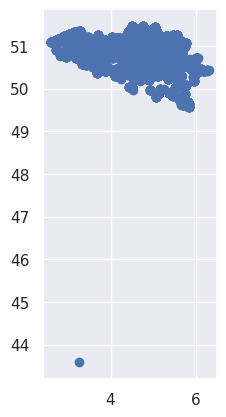

In [392]:
geocoded_data[geocoded_data.point.notnull()].set_geometry("point").plot()

In [393]:
geocoded_data = geocoded_data[geocoded_data.point.notnull()] 

In [394]:
geocoded_data = gpd.GeoDataFrame(geocoded_data).set_geometry("point").set_crs(osm_crs, allow_override=True).to_crs(crs)
geocoded_data

reference_key                   street housenumber postcode  \
0                 0     Dendermondsesteenweg         200     2830   
1                 1      Boulevard du Régent          47     1000   
2                 2                 Hauwaart          44     9700   
3                 3          Bruynebosstraat          40     3511   
4                 4        Steenwinkelstraat         583     2627   
...             ...                      ...         ...      ...   
6995            995          Route de Marche          43     6940   
6996            996  Godfried van Leuvenlaan           8     1600   
6997            997               Valleilaan          83     3290   
6998            998              Venusstraat           2     2000   
6999            999             Voie Jocquée          10     6830   

                    city                                            address  \
0             Willebroek  Dendermondsesteenweg, 200, 2830 Willebroek, Be...   
1              Bruxelles  Boulevard du Régent, 47, 1000 Bruxelles, Belgique   
2             Oudenaarde            Hauwaart, 44, 9700 Oudenaarde, Belgique   
3                Hasselt        Bruynebosstraat, 40, 3511 Hasselt, Belgique   
4                Schelle     Steenwinkelstraat, 583, 2627 Schelle, Belgique   
...                  ...                                                ...   
6995              Durbuy         Route de Marche, 43, 6940 Durbuy, Belgique   
6996  Sint-Pieters-Leeuw  Godfried van Leuvenlaan, 8, 1600 Sint-Pieters-...   
6997               Diest               Valleilaan, 83, 3290 Diest, Belgique   
6998           Antwerpen           Venusstraat, 2, 2000 Antwerpen, Belgique   
6999            Bouillon          Voie Jocquée, 10, 6830 Bouillon, Belgique   

                                               location geocoder  duration  \
0     (Dendermondsesteenweg 200, Willebroek, Flemish...     bing  0.344215   
1     (Boulevard du Régent 47, Brussels, Brussels Re...     bing  0.227624   
2     (Hauwaart 44, Oudenaarde, Flemish Region 9700,...     bing  0.217501   
3     (Bruynebosstraat 40, Hasselt, Flemish Region 3...     bing  0.200409   
4     (Steenwinkelstraat 583, Schelle, Flemish Regio...     bing  0.216945   
...                                                 ...      ...       ...   
6995  (43, Route de Marche, 6940, Route de Marche, D...   photon  0.013409   
6996  (8, Godfried van Leuvenlaan, 1600, Godfried va...   photon  0.014387   
6997  (83, Valleilaan, 3290, Valleilaan, Diest, Vlaa...   photon  0.009726   
6998  (2, Venusstraat, 2000, Venusstraat, Antwerpen,...   photon  0.010481   
6999  (10, Voie Jocquée, 6830, Voie Jocquée, Bouillo...   photon  0.011782   

     precision                           point  
0     building  POINT (483924.851 6631803.785)  
1     building  POINT (486333.181 6594343.330)  
2     building  POINT (407795.333 6591583.109)  
3     building  POINT (586173.740 6617374.917)  
4     building  POINT (486026.841 6643019.569)  
...        ...                             ...  
6995  building  POINT (611105.400 6506694.506)  
6996  building  POINT (477289.412 6586081.235)  
6997  building  POINT (562012.222 6619229.827)  
6998  building  POINT (490813.231 6661165.572)  
6999  building  POINT (564539.840 6410883.792)  

[6863 rows x 11 columns]

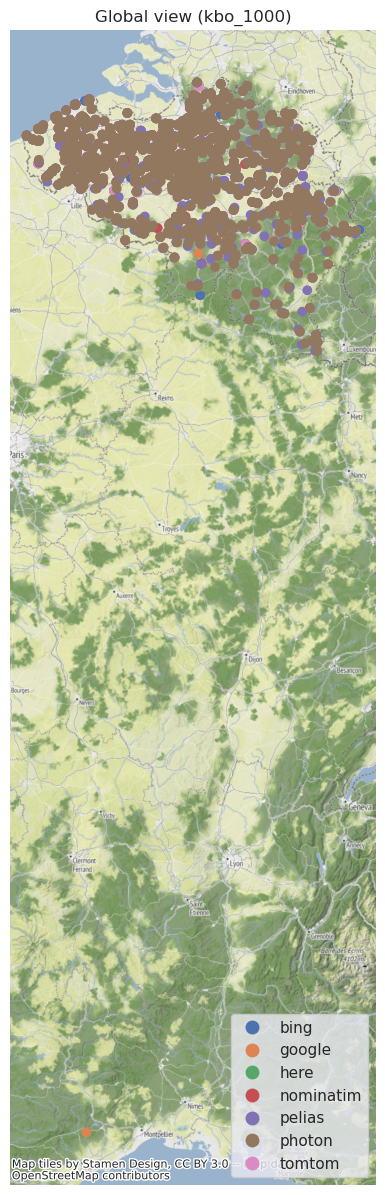

In [395]:
from matplotlib.colors import ListedColormap

colors = ListedColormap([f"C{i}" for i in range(geocoded_data.geocoder.nunique())], name="mycmap")
ax=geocoded_data.plot("geocoder", legend=True, figsize=(10,15), cmap=colors)
plt.title(f"Global view ({dataset})")
add_basemap(ax)
# img_name=f"{fig_path}/global_{dataset}.png"
# plt.savefig(img_name,  bbox_inches='tight')
# pdf_add_image(pdf, img_name)
# pdf.add_page()
# pdf.image(f"{fig_path}/global_{dataset}.png", 0, 0, 290)
plt.axis("off")
pdf.savefig( bbox_inches='tight')
# plt.show()
# plt.close()

In [396]:
belgium_boundaries = gpd.read_file("data/boundaries.geojson", driver="GeoJSON")
belgium_boundaries = belgium_boundaries[belgium_boundaries.name == "BEL"].geometry.iloc[0].simplify(1000).buffer(1000)
# belgium_boundaries

In [397]:
geocoded_data["is_in_belgium"]= geocoded_data.geometry.within(belgium_boundaries)
geocoded_data["is_in_belgium"].value_counts()

True     6862
False       1
Name: is_in_belgium, dtype: int64

In [398]:
geocoded_data[~geocoded_data.is_in_belgium]

reference_key                      street housenumber postcode  \
1562            562  Rue Emile Vandervelde(PIR)         34+     6240   

            city                                            address  \
1562  Farciennes  Rue Emile Vandervelde(PIR), 34+, 6240 Farcienn...   

                                        location geocoder  duration precision  \
1562  (Hérault, France, (43.5912356, 3.2583626))   google  0.121799      city   

                               point  is_in_belgium  
1562  POINT (362719.265 5402401.329)          False

In [399]:
geocoded_data.groupby("geocoder").is_in_belgium.value_counts()

geocoder   is_in_belgium
bing       True             1000
google     True              999
           False               1
here       True             1000
nominatim  True              869
pelias     True              997
photon     True              997
tomtom     True             1000
Name: is_in_belgium, dtype: int64

In [400]:
geocoded_data[~geocoded_data.is_in_belgium]

reference_key                      street housenumber postcode  \
1562            562  Rue Emile Vandervelde(PIR)         34+     6240   

            city                                            address  \
1562  Farciennes  Rue Emile Vandervelde(PIR), 34+, 6240 Farcienn...   

                                        location geocoder  duration precision  \
1562  (Hérault, France, (43.5912356, 3.2583626))   google  0.121799      city   

                               point  is_in_belgium  
1562  POINT (362719.265 5402401.329)          False

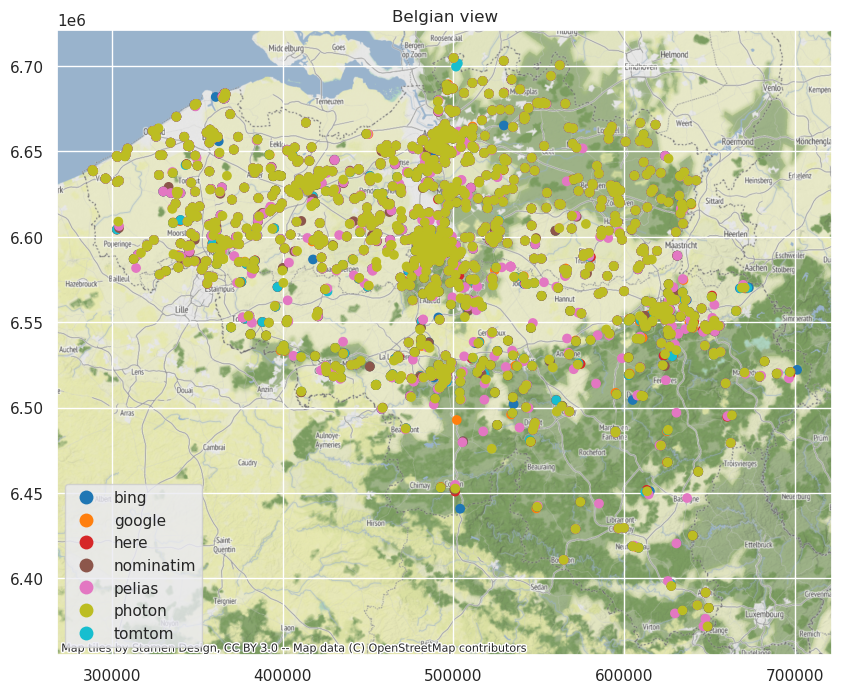

In [401]:
ax=geocoded_data[geocoded_data.is_in_belgium].plot("geocoder", legend=True, figsize=(10,15))
plt.title("Belgian view")
add_basemap(ax)
pdf.savefig(bbox_inches='tight')


## Compute (distance to) median

In [402]:
def get_median_point(bloc):
    bloc = gpd.GeoSeries(bloc.dropna())
    x = np.median(bloc.x)
    y = np.median(bloc.y)
    return shapely.geometry.Point(x, y), bloc.shape[0]
 

In [403]:
# geocoded_data.address.drop_duplicates()

In [404]:
median_geocoders = coders # ["here", "bing", "mapbox", "tomtom", "nominatim_wrapper", "google", "bestaddress"] # Median based on those geocoders
median_points = geocoded_data[geocoded_data.geocoder.isin(median_geocoders)&( geocoded_data.precision=="building") ].groupby("address").point.apply(get_median_point).apply(pd.Series)#.rename("median_point").reset_index()
median_points = median_points.rename(columns={0: "median_point", 1: "nb_points"}).reset_index()
median_points = median_points.set_geometry("median_point").set_crs(geocoded_data.crs)
median_points

address  \
0                   't Pand, 10, 8000 Brugge, Belgique   
1       Aaigembergstraat, 28, 9420 Erpe-Mere, Belgique   
2          Aarschotsebaan, 127, 2590 Berlaar, Belgique   
3       Aarschotsesteenweg, 163, 3010 Leuven, Belgique   
4       Aarschotsesteenweg, 830, 3012 Leuven, Belgique   
..                                                 ...   
983      de Fierlantstraat, 9, 1933 Zaventem, Belgique   
984  de Selliers de Moranvillelaan, 8, 2820 Bonheid...   
985          de Stuersstraat, 20, 8900 Ieper, Belgique   
986                le Roylaan, 3, 2520 Ranst, Belgique   
987  rue Théodore De Cuyper, 121, 1200 Woluwe-Saint...   

                       median_point  nb_points  
0    POINT (359510.812 6657891.196)          7  
1    POINT (437534.708 6600233.423)          7  
2    POINT (519329.754 6636074.135)          7  
3    POINT (524679.523 6605537.214)          4  
4    POINT (526093.665 6609362.428)          7  
..                              ...        ...  
983  POINT (501443.322 6595106.202)          6  
984  POINT (506783.095 6624991.524)          7  
985  POINT (320616.831 6594822.584)          3  
986  POINT (510574.832 6659884.166)          6  
987  POINT (493584.166 6595039.216)          6  

[988 rows x 3 columns]

<Axes: ylabel='nb_points'>

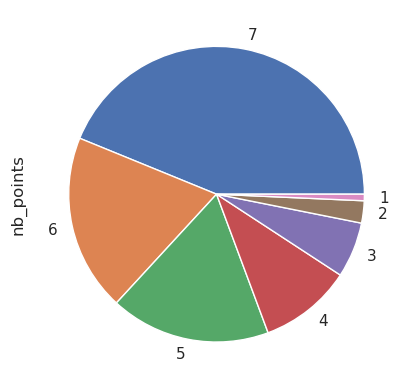

In [405]:
median_points.nb_points.value_counts().plot.pie()

In [406]:
median_points = median_points[median_points.nb_points >= min(3,median_points.nb_points.max()) ]
median_points.shape

(957, 3)

In [407]:
geocoded_data = geocoded_data.merge(median_points, how="left")#.dropna()
# geocoded_data

In [408]:
geocoded_data["dist_to_median"] = geocoded_data.point.distance(geocoded_data.median_point.set_crs(geocoded_data.crs))
geocoded_data.sort_values("dist_to_median")#.tail(100)

reference_key                     street housenumber postcode  \
6862            999               Voie Jocquée          10     6830   
4529            601                    't Pand          10     8000   
4539            612               Meibosstraat          25     8780   
4613            700             Begijnengracht           9     9000   
4648            741        Victor Bocquéstraat           5     9300   
...             ...                        ...         ...      ...   
6790            926      Avenue Max Buset(L.L)          35     7100   
6807            944      Chaussée des Collines           /     1300   
6844            981  Avenue Alexandre Duchesne           /     4802   
6852            989      Rue Combattants(Haul)          20     7120   
6853            990                  Wirtzfeld         116     4761   

              city                                            address  \
6862      Bouillon          Voie Jocquée, 10, 6830 Bouillon, Belgique   
4529        Brugge                 't Pand, 10, 8000 Brugge, Belgique   
4539  Oostrozebeke      Meibosstraat, 25, 8780 Oostrozebeke, Belgique   
4613          Gent             Begijnengracht, 9, 9000 Gent, Belgique   
4648         Aalst       Victor Bocquéstraat, 5, 9300 Aalst, Belgique   
...            ...                                                ...   
6790   La Louvière  Avenue Max Buset(L.L), 35, 7100 La Louvière, B...   
6807         Wavre     Chaussée des Collines, /, 1300 Wavre, Belgique   
6844      Verviers  Avenue Alexandre Duchesne, /, 4802 Verviers, B...   
6852      Estinnes  Rue Combattants(Haul), 20, 7120 Estinnes, Belg...   
6853     Büllingen           Wirtzfeld, 116, 4761 Büllingen, Belgique   

                                               location   geocoder  duration  \
6862  (10, Voie Jocquée, 6830, Voie Jocquée, Bouillo...     photon  0.011782   
4529  (10, 't Pand, Magdalenakwartier, Brugge-Centru...  nominatim  0.008704   
4539  (25, Meibosstraat, Oostrozebeke, Tielt, West-V...  nominatim  0.008946   
4613  (9, Begijnengracht, Elisabethbegijnhof, Gent, ...  nominatim  0.009428   
4648  (5, Victor Bocquestraat, Aalst, Oost-Vlaandere...  nominatim  0.009930   
...                                                 ...        ...       ...   
6790  (Avenue Max Buset, 7100, La Louvière, Hainaut,...     photon  0.094185   
6807  (Ancienne Chaussée des Collines, 1300, Wavre, ...     photon  0.013921   
6844  (Avenue Alexandre Duchesne, 4800, Verviers, Li...     photon  0.071274   
6852  (Rue des Combattants, 7120, Haulchin, Hainaut,...     photon  0.064351   
6853  (Wirtzfeld, 4761, Büllingen, Liège, België / B...     photon  0.043783   

     precision                           point  is_in_belgium  \
6862  building  POINT (564539.840 6410883.792)           True   
4529  building  POINT (359510.812 6657891.196)           True   
4539  building  POINT (372417.257 6608164.998)           True   
4613  building  POINT (413414.969 6631233.344)           True   
4648  building  POINT (449568.824 6612813.421)           True   
...        ...                             ...            ...   
6790    street  POINT (467740.010 6528853.060)           True   
6807    street  POINT (512630.786 6574767.861)           True   
6844    street  POINT (653788.197 6548389.023)           True   
6852    street  POINT (454509.510 6513199.367)           True   
6853      city  POINT (697072.365 6520800.260)           True   

                        median_point  nb_points  dist_to_median  
6862  POINT (564539.840 6410883.792)        6.0             0.0  
4529  POINT (359510.812 6657891.196)        7.0             0.0  
4539  POINT (372417.257 6608164.998)        7.0             0.0  
4613  POINT (413414.969 6631233.344)        7.0             0.0  
4648  POINT (449568.824 6612813.421)        7.0             0.0  
...                              ...        ...             ...  
6790                            None        NaN             NaN  
6807  

In [409]:
# geocoded_data[geocoded_data.median_point.isnull()].sort_values("address")

In [410]:
# geocoded_data.sort_values("dist_to_median").tail(40).geocoder.value_counts().plot.bar()

In [411]:
def plot_address(geocoded_data, a):
    df = geocoded_data[(geocoded_data.address==a)]
    display(df)
    

    ax = df.assign(label=df.geocoder + " ("+df.dist_to_median.fillna(-1).astype(int).astype(str) + " - " + df.precision + ")").plot(
        "label", 
        legend=True, 
        markersize=100,
            figsize=(10,12)
    )

    if df.dist_to_median.isnull().all():
        print("No median point")
    else: 
        med=df[["median_point"]].drop_duplicates().set_geometry("median_point")
                                                                                                                         
        med.plot(ax=ax, color="red", marker="x", markersize=100)
    ax.set_title(a)
    set_optimal_limits(ax, df)
    add_basemap(ax)
    plt.show()    
    return ax

In [412]:
# plot_address(geocoded_data, geocoded_data.loc[46].address)

reference_key                      street housenumber postcode  \
562             562  Rue Emile Vandervelde(PIR)         34+     6240   
1562            562  Rue Emile Vandervelde(PIR)         34+     6240   
2562            562  Rue Emile Vandervelde(PIR)         34+     6240   
3562            562  Rue Emile Vandervelde(PIR)         34+     6240   
5428            562  Rue Emile Vandervelde(PIR)         34+     6240   
6426            562  Rue Emile Vandervelde(PIR)         34+     6240   

            city                                            address  \
562   Farciennes  Rue Emile Vandervelde(PIR), 34+, 6240 Farcienn...   
1562  Farciennes  Rue Emile Vandervelde(PIR), 34+, 6240 Farcienn...   
2562  Farciennes  Rue Emile Vandervelde(PIR), 34+, 6240 Farcienn...   
3562  Farciennes  Rue Emile Vandervelde(PIR), 34+, 6240 Farcienn...   
5428  Farciennes  Rue Emile Vandervelde(PIR), 34+, 6240 Farcienn...   
6426  Farciennes  Rue Emile Vandervelde(PIR), 34+, 6240 Farcienn...   

                                               location geocoder  duration  \
562   (Rue Emile Vandervelde 34, Farciennes, Walloon...     bing  0.237390   
1562         (Hérault, France, (43.5912356, 3.2583626))   google  0.121799   
2562  (Rue Émile Vandervelde 34, 6240 Farciennes, Be...     here  0.128535   
3562  (Rue Émile Vandervelde 34, 6240 Farciennes, (5...   tomtom  0.188085   
5428                  (Farciennes, (50.43006, 4.54152))   pelias  0.021098   
6426  (34, Rue Émile Vandervelde, 6240, Rue Émile Va...   photon  0.013616   

     precision                           point  is_in_belgium  \
562   building  POINT (504455.839 6520123.066)           True   
1562      city  POINT (362719.265 5402401.329)          False   
2562  building  POINT (504455.404 6520122.419)           True   
3562  building  POINT (504455.404 6520122.419)           True   
5428      city  POINT (505559.694 6521090.481)           True   
6426  building  POINT (504455.836 6520122.926)           True   

                        median_point  nb_points  dist_to_median  
562   POINT (504455.620 6520122.673)        4.0    4.497664e-01  
1562  POINT (504455.620 6520122.673)        4.0    1.126672e+06  
2562  POINT (504455.620 6520122.673)        4.0    3.327268e-01  
3562  POINT (504455.620 6520122.673)        4.0    3.327268e-01  
5428  POINT (504455.620 6520122.673)        4.0    1.468207e+03  
6426  POINT (504455.620 6520122.673)        4.0    3.327268e-01

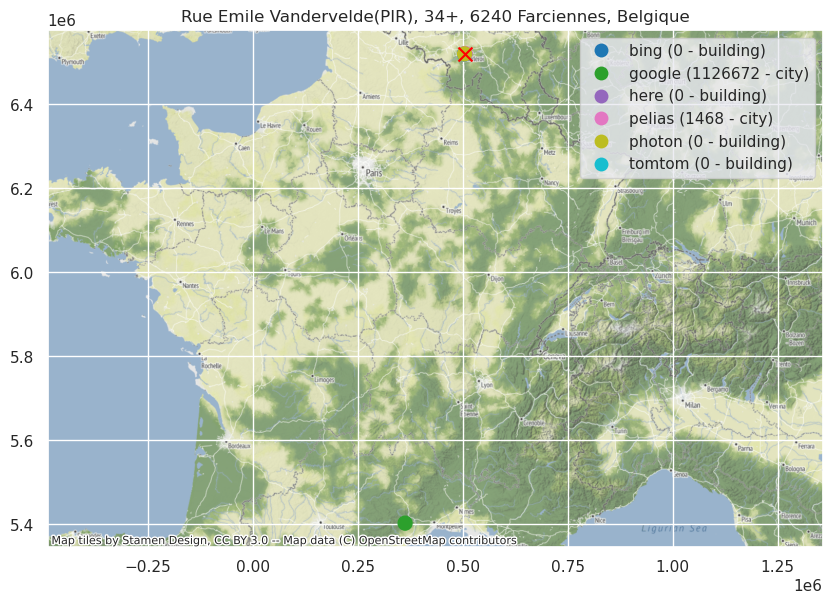

reference_key                 street housenumber postcode   city  \
918             918  Chemin de la Goutaine          6A     6720  Habay   
1918            918  Chemin de la Goutaine          6A     6720  Habay   
2918            918  Chemin de la Goutaine          6A     6720  Habay   
3918            918  Chemin de la Goutaine          6A     6720  Habay   
4802            918  Chemin de la Goutaine          6A     6720  Habay   
5784            918  Chemin de la Goutaine          6A     6720  Habay   
6782            918  Chemin de la Goutaine          6A     6720  Habay   

                                              address  \
918   Chemin de la Goutaine, 6A, 6720 Habay, Belgique   
1918  Chemin de la Goutaine, 6A, 6720 Habay, Belgique   
2918  Chemin de la Goutaine, 6A, 6720 Habay, Belgique   
3918  Chemin de la Goutaine, 6A, 6720 Habay, Belgique   
4802  Chemin de la Goutaine, 6A, 6720 Habay, Belgique   
5784  Chemin de la Goutaine, 6A, 6720 Habay, Belgique   
6782  Chemin de la Goutaine, 6A, 6720 Habay, Belgique   

                                               location   geocoder  duration  \
918   (Chemin de la Fontaine 6A, Genappe, Walloon Re...       bing  0.431361   
1918  (Chem. de la Goutaine 6A, 6720 Habay, Belgium,...     google  0.095241   
2918  (Chemin de la Goutaine 6A, 6723 Habay, Belgiqu...       here  0.160780   
3918  (Chemin de la Goutaine 6, 6720 Habay, (49.7145...     tomtom  0.224769   
4802  (Chemin de la Goutaine, Habay-la-Vieille, Haba...  nominatim  0.018908   
5784            (Habay-la-Vieille, (49.72329, 5.61999))     pelias  0.016519   
6782  (Chemin de la Goutaine, 6723, Habay-la-Vieille...     photon  0.068773   

     precision                           point  is_in_belgium  \
918   building  POINT (491191.598 6552827.626)           True   
1918  building  POINT (627170.794 6396934.464)           True   
2918  building  POINT (627170.672 6396935.256)           True   
3918    street  POINT (627179.577 6396988.626)           True   
4802    street  POINT (627559.010 6395599.959)           True   
5784      city  POINT (625614.425 6398491.739)           True   
6782    street  POINT (627559.010 6395599.959)           True   

                        median_point  nb_points  dist_to_median  
918   POINT (627170.672 6396935.256)        3.0   206864.059820  
1918  POINT (627170.672 6396935.256)        3.0        0.801353  
2918  POINT (627170.672 6396935.256)        3.0        0.000000  
3918  POINT (627170.672 6396935.256)        3.0       54.108072  
4802  POINT (627170.672 6396935.256)        3.0     1390.619904  
5784  POINT (627170.672 6396935.256)        3.0     2201.031960  
6782  POINT (627170.672 6396935.256)        3.0     1390.619904

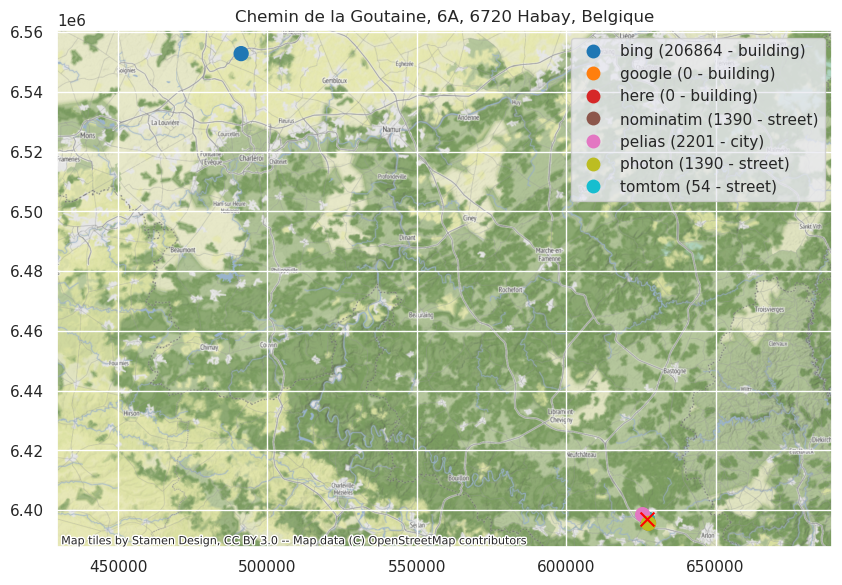

reference_key          street housenumber postcode           city  \
540             540  Rue de Tilleur          54     4420  Saint-Nicolas   
1540            540  Rue de Tilleur          54     4420  Saint-Nicolas   
2540            540  Rue de Tilleur          54     4420  Saint-Nicolas   
3540            540  Rue de Tilleur          54     4420  Saint-Nicolas   
4479            540  Rue de Tilleur          54     4420  Saint-Nicolas   
5406            540  Rue de Tilleur          54     4420  Saint-Nicolas   
6404            540  Rue de Tilleur          54     4420  Saint-Nicolas   

                                               address  \
540   Rue de Tilleur, 54, 4420 Saint-Nicolas, Belgique   
1540  Rue de Tilleur, 54, 4420 Saint-Nicolas, Belgique   
2540  Rue de Tilleur, 54, 4420 Saint-Nicolas, Belgique   
3540  Rue de Tilleur, 54, 4420 Saint-Nicolas, Belgique   
4479  Rue de Tilleur, 54, 4420 Saint-Nicolas, Belgique   
5406  Rue de Tilleur, 54, 4420 Saint-Nicolas, Belgique   
6404  Rue de Tilleur, 54, 4420 Saint-Nicolas, Belgique   

                                               location   geocoder  duration  \
540   (Rue de Tilleur 54, Saint-Nicolas, Walloon Reg...       bing  0.397262   
1540  (Rue Marquet 54, 4420 Saint-Nicolas, Belgium, ...     google  0.110165   
2540  (Rue de Tilleur 54, 4420 Saint-Nicolas, Belgiq...       here  0.046023   
3540  (Rue de la Cité 54, 4420 Saint-Nicolas, (50.61...     tomtom  0.292816   
4479  (54, Rue de Tilleur, Tilleur, Saint-Nicolas, L...  nominatim  0.011881   
5406                (St Nicolas, (51.163886, 4.139404))     pelias  0.023967   
6404  (54, Rue de Tilleur, 4420, Rue de Tilleur, Sai...     photon  0.014565   

     precision                           point  is_in_belgium  \
540   building  POINT (617264.484 6556197.399)           True   
1540  building  POINT (614539.549 6554356.104)           True   
2540  building  POINT (617379.009 6556318.245)           True   
3540  building  POINT (615804.952 6554261.675)           True   
4479  building  POINT (617379.008 6556318.552)           True   
5406      city  POINT (460796.345 6650334.618)           True   
6404  building  POINT (617379.008 6556318.552)           True   

                        median_point  nb_points  dist_to_median  
540   POINT (617321.746 6556257.822)        6.0       83.246129  
1540  POINT (617321.746 6556257.822)        6.0     3370.036478  
2540  POINT (617321.746 6556257.822)        6.0       83.246979  
3540  POINT (617321.746 6556257.822)        6.0     2507.043708  
4479  POINT (617321.746 6556257.822)        6.0       83.469315  
5406  POINT (617321.746 6556257.822)        6.0   182621.588386  
6404  POINT (617321.746 6556257.822)        6.0       83.469315

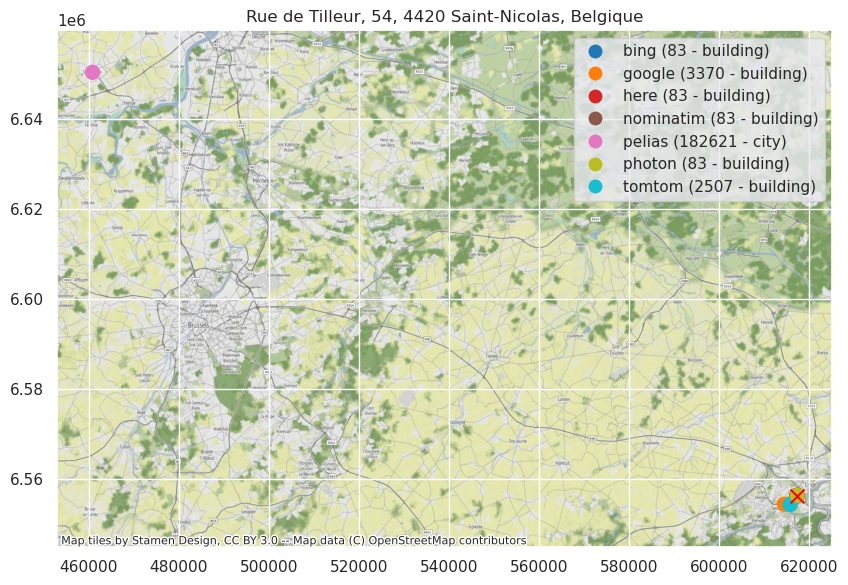

reference_key            street housenumber postcode     city  \
219             219  Rue de Pont(TOU)        3/11     7500  Tournai   
1219            219  Rue de Pont(TOU)        3/11     7500  Tournai   
2219            219  Rue de Pont(TOU)        3/11     7500  Tournai   
3219            219  Rue de Pont(TOU)        3/11     7500  Tournai   
5087            219  Rue de Pont(TOU)        3/11     7500  Tournai   
6083            219  Rue de Pont(TOU)        3/11     7500  Tournai   

                                             address  \
219   Rue de Pont(TOU), 3/11, 7500 Tournai, Belgique   
1219  Rue de Pont(TOU), 3/11, 7500 Tournai, Belgique   
2219  Rue de Pont(TOU), 3/11, 7500 Tournai, Belgique   
3219  Rue de Pont(TOU), 3/11, 7500 Tournai, Belgique   
5087  Rue de Pont(TOU), 3/11, 7500 Tournai, Belgique   
6083  Rue de Pont(TOU), 3/11, 7500 Tournai, Belgique   

                                               location geocoder  duration  \
219   (Rue de Pont 3, Tournai, Walloon Region 7500, ...     bing  0.251189   
1219  (Rue de Pont, 7500 Tournai, Belgium, (50.60705...   google  0.113394   
2219  (Rue de Pont 3, 7500 Tournai, Belgique, Tourna...     here  0.078860   
3219  (Rue de Pont 3, 7500 Tournai, (50.60686, 3.393...   tomtom  0.334718   
5087                    (Tournai, (50.611197, 3.38332))   pelias  0.035587   
6083  (Grottes de Goyet (accès touristique), 3, Rue ...   photon  0.099534   

     precision                           point  is_in_belgium  \
219   building  POINT (377790.544 6552044.241)           True   
1219    street  POINT (377791.891 6552078.744)           True   
2219  building  POINT (377790.522 6552044.241)           True   
3219  building  POINT (377790.522 6552044.241)           True   
5087      city  POINT (376629.460 6552805.014)           True   
6083  building  POINT (558169.812 6523563.202)           True   

                        median_point  nb_points  dist_to_median  
219   POINT (377790.533 6552044.241)        4.0        0.011132  
1219  POINT (377790.533 6552044.241)        4.0       34.529207  
2219  POINT (377790.533 6552044.241)        4.0        0.011132  
3219  POINT (377790.533 6552044.241)        4.0        0.011132  
5087  POINT (377790.533 6552044.241)        4.0     1388.115880  
6083  POINT (377790.533 6552044.241)        4.0   182613.947514

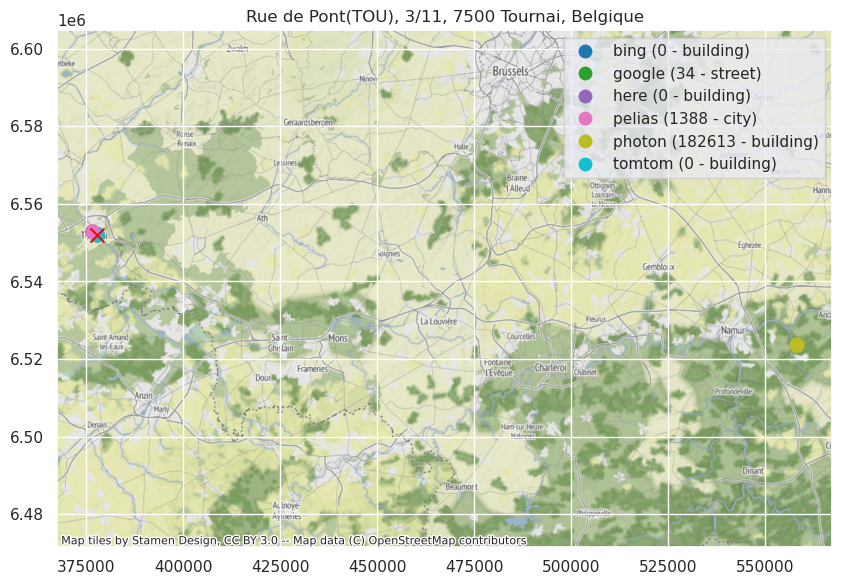

reference_key              street housenumber postcode      city  \
30               30  Oostwinkeldorp(OW)           2     9931  Lievegem   
1030             30  Oostwinkeldorp(OW)           2     9931  Lievegem   
2030             30  Oostwinkeldorp(OW)           2     9931  Lievegem   
3030             30  Oostwinkeldorp(OW)           2     9931  Lievegem   
4899             30  Oostwinkeldorp(OW)           2     9931  Lievegem   
5896             30  Oostwinkeldorp(OW)           2     9931  Lievegem   

                                             address  \
30    Oostwinkeldorp(OW), 2, 9931 Lievegem, Belgique   
1030  Oostwinkeldorp(OW), 2, 9931 Lievegem, Belgique   
2030  Oostwinkeldorp(OW), 2, 9931 Lievegem, Belgique   
3030  Oostwinkeldorp(OW), 2, 9931 Lievegem, Belgique   
4899  Oostwinkeldorp(OW), 2, 9931 Lievegem, Belgique   
5896  Oostwinkeldorp(OW), 2, 9931 Lievegem, Belgique   

                                               location geocoder  duration  \
30    (Oostwinkeldorp 2, Oostwinkel, Flemish Region ...     bing  0.199910   
1030  (Oostwinkeldorp, 9931 Lievegem, Belgium, (51.1...   google  0.107562   
2030  (Oostwinkeldorp 2, 9931 Lievegem, België, Liev...     here  0.069600   
3030  (Oostwinkeldorp 2, 9931 Lievegem, (51.15136, 3...   tomtom  0.168455   
4899                   (Belgium, (50.780688, 4.792712))   pelias  0.012852   
5896  (Oostwinkeldorp, 9931, Oostwinkel, Oost-Vlaand...   photon  0.074571   

     precision                           point  is_in_belgium  \
30    building  POINT (392117.429 6648112.151)           True   
1030    street  POINT (392435.324 6648020.915)           True   
2030  building  POINT (392128.472 6648118.451)           True   
3030  building  POINT (392117.340 6648111.352)           True   
4899   country  POINT (533522.259 6582591.273)           True   
5896    street  POINT (392157.115 6648130.519)           True   

                        median_point  nb_points  dist_to_median  
30    POINT (392117.429 6648112.151)        3.0        0.000000  
1030  POINT (392117.429 6648112.151)        3.0      330.728356  
2030  POINT (392117.429 6648112.151)        3.0       12.713653  
3030  POINT (392117.429 6648112.151)        3.0        0.803556  
4899  POINT (392117.429 6648112.151)        3.0   155847.076965  
5896  POINT (392117.429 6648112.151)        3.0       43.729999

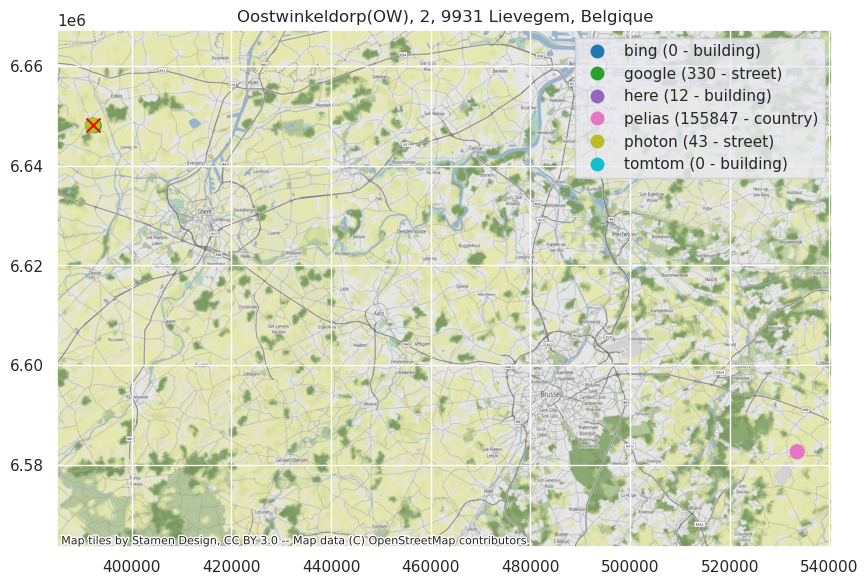

In [413]:
for a in geocoded_data.sort_values("dist_to_median", ascending=False).address.unique()[0:5]:
    #print(a)
    plot_address(geocoded_data, a)
   

## Median pertinence

How many close to median ?

In [414]:
nb_close_to_median = geocoded_data.assign(close_to_median = geocoded_data.dist_to_median < 100).groupby("address").close_to_median.sum()
nb_close_to_median

address
't Pand, 10, 8000 Brugge, Belgique                                  7
Aaigembergstraat, 28, 9420 Erpe-Mere, Belgique                      7
Aarschotsebaan, 127, 2590 Berlaar, Belgique                         7
Aarschotsesteenweg, 163, 3010 Leuven, Belgique                      5
Aarschotsesteenweg, 830, 3012 Leuven, Belgique                      7
                                                                   ..
de Fierlantstraat, 9, 1933 Zaventem, Belgique                       5
de Selliers de Moranvillelaan, 8, 2820 Bonheiden, Belgique          7
de Stuersstraat, 20, 8900 Ieper, Belgique                           5
le Roylaan, 3, 2520 Ranst, Belgique                                 6
rue Théodore De Cuyper, 121, 1200 Woluwe-Saint-Lambert, Belgique    6
Name: close_to_median, Length: 1000, dtype: int64

In [415]:
median_points = median_points.merge(nb_close_to_median.rename("nb_close_to_median").reset_index())

In [416]:
median_points.nb_close_to_median.value_counts()

7    435
6    191
5    175
4    102
3     43
2      5
1      4
0      2
Name: nb_close_to_median, dtype: int64

In [417]:
median_points[median_points.nb_close_to_median>=2]

address  \
0                   't Pand, 10, 8000 Brugge, Belgique   
1       Aaigembergstraat, 28, 9420 Erpe-Mere, Belgique   
2          Aarschotsebaan, 127, 2590 Berlaar, Belgique   
3       Aarschotsesteenweg, 163, 3010 Leuven, Belgique   
4       Aarschotsesteenweg, 830, 3012 Leuven, Belgique   
..                                                 ...   
952      de Fierlantstraat, 9, 1933 Zaventem, Belgique   
953  de Selliers de Moranvillelaan, 8, 2820 Bonheid...   
954          de Stuersstraat, 20, 8900 Ieper, Belgique   
955                le Roylaan, 3, 2520 Ranst, Belgique   
956  rue Théodore De Cuyper, 121, 1200 Woluwe-Saint...   

                       median_point  nb_points  nb_close_to_median  
0    POINT (359510.812 6657891.196)          7                   7  
1    POINT (437534.708 6600233.423)          7                   7  
2    POINT (519329.754 6636074.135)          7                   7  
3    POINT (524679.523 6605537.214)          4                   5  
4    POINT (526093.665 6609362.428)          7                   7  
..                              ...        ...                 ...  
952  POINT (501443.322 6595106.202)          6                   5  
953  POINT (506783.095 6624991.524)          7                   7  
954  POINT (320616.831 6594822.584)          3                   5  
955  POINT (510574.832 6659884.166)          6                   6  
956  POINT (493584.166 6595039.216)          6                   6  

[951 rows x 4 columns]

In [418]:
# nb_close_to_median.value_counts()

In [419]:
geocoded_data = geocoded_data.merge(median_points, how="left")

In [420]:
geocoded_data.loc[geocoded_data.nb_close_to_median <2, "dist_to_median"] = pd.NA

In [421]:
geocoded_data[geocoded_data.dist_to_median.notnull()].address.nunique()

951

In [422]:
for a in nb_close_to_median[nb_close_to_median==0].iloc[0:4].index:
    if geocoded_data[geocoded_data.address == a].median_point.notnull().any():
        plot_address(geocoded_data[geocoded_data.median_point.notnull()], a)

## Add selectors

In [423]:
geocoded_data["has_median"] = geocoded_data.dist_to_median.notnull()
geocoded_data["has_median"].value_counts()

True     6544
False     319
Name: has_median, dtype: int64

In [424]:
geocoded_data[geocoded_data["has_median"]].address.nunique()

951

In [425]:
# geocoded_data["is_median_reliable"] =   geocoded_data["nb_close_to_median"]>=2
# geocoded_data.is_median_reliable.value_counts()

In [426]:
# geocoded_data["is_value_normal"]    = geocoded_data.dist_to_median < geocoded_data.dist_to_median.quantile(0.995)
# geocoded_data.is_value_normal.value_counts() # / geocoded_data.shape[0]

In [427]:
# geocoded_data["less_than_10km"]    = geocoded_data.dist_to_median < 10000
# geocoded_data.less_than_10km.value_counts() # / geocoded_data.shape[0]

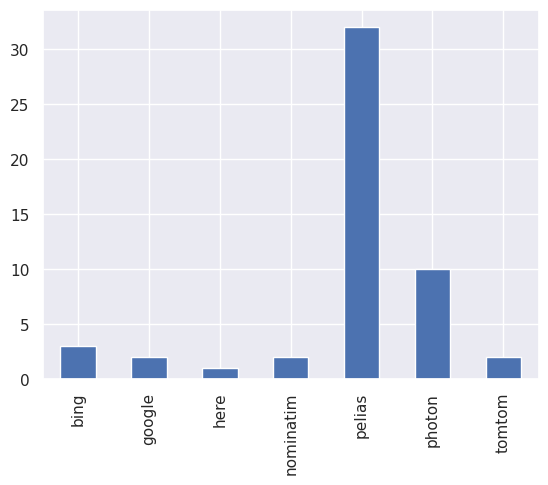

In [428]:
vc = geocoded_data[(geocoded_data.dist_to_median > 10000)].geocoder.value_counts().sort_index()
if vc.shape[0]>0:
    vc.plot.bar()

In [429]:
# geocoded_data.dist_to_median.quantile(0.99)

In [430]:
# pd.crosstab(geocoded_data.is_value_normal, geocoded_data.is_in_belgium)

## Distance to median

### Average

geocoder
bing          447.616088
google       1291.281446
here           39.988390
nominatim     219.399157
pelias       2742.957880
photon        766.932227
tomtom         59.269273
Name: dist_to_median, dtype: float64

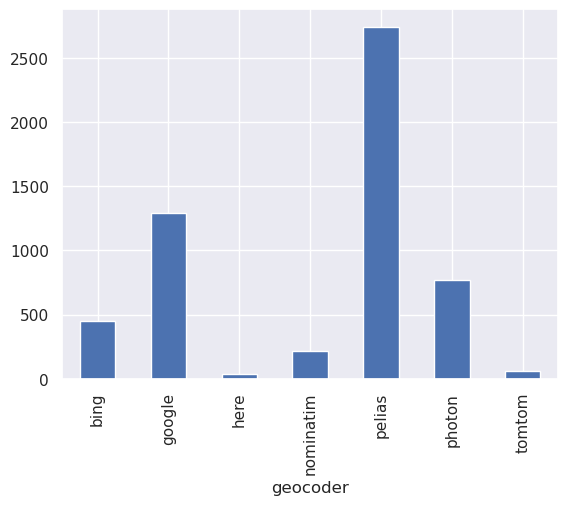

In [431]:
# d2m = geocoded_data.groupby("geocoder").dist_to_median.mean()
d2m = geocoded_data.groupby("geocoder").dist_to_median.mean()
d2m.plot.bar()
# plt.savefig(f"{fig_path}/dist2med_{dataset}.png")
d2m

geocoder
bing          447.616088
google        106.669975
here           39.988390
nominatim     219.399157
pelias       2742.957880
photon        766.932227
tomtom         59.269273
Name: dist_to_median, dtype: float64

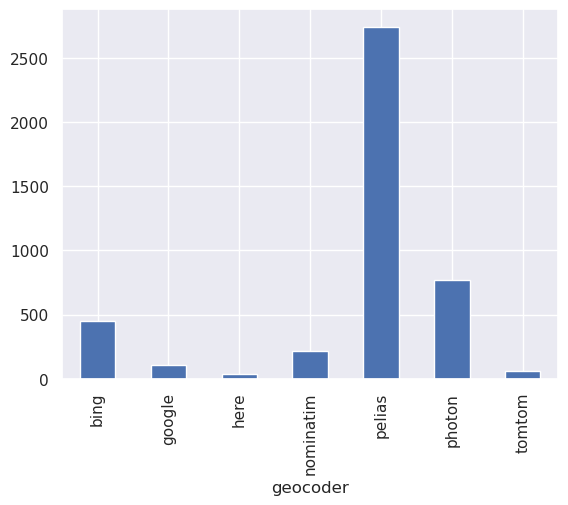

In [432]:
# skipping non reliable median

# d2m = geocoded_data[geocoded_data.is_reliable].groupby("geocoder").dist_to_median.mean()
d2m = geocoded_data[geocoded_data.is_in_belgium].groupby("geocoder").dist_to_median.mean()
d2m.plot.bar()
# plt.savefig(f"{fig_path}/dist2med_reliable_{dataset}.png")
d2m

### Percentiles

In [433]:
#[geocoded_data.precision=="building"]#.drop_duplicates(subset="address")
# from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import LogLocator
def dist_to_median_line_plot(d, ax=None, title=None, legend=True):
    mean = d.groupby("geocoder").dist_to_median.mean().rename("Mean")

    perc_90 = d.groupby("geocoder").dist_to_median.quantile(0.90).rename("Perc 90%")
    perc_95 = d.groupby("geocoder").dist_to_median.quantile(0.95).rename("Perc 95%")
    perc_99 = d.groupby("geocoder").dist_to_median.quantile(0.99).rename("Perc 99%")
    perc_50 = d.groupby("geocoder").dist_to_median.quantile(0.50).rename("Median")
    maxd = d.groupby("geocoder").dist_to_median.max().rename("Max")
    tops = [ d.groupby("geocoder").dist_to_median.nlargest(i).reset_index().groupby("geocoder").dist_to_median.min() for i in range(2, 50)]#.drop_index(level=1)#@@.tail(1)#.unstack()
#     mean    = mean.sort_values()
#     perc_90 = perc_90.reindex_like(mean)
#     perc_99 = perc_99.reindex_like(mean)
#     perc_50 = perc_50.reindex_like(mean)
#     maxd =    maxd.reindex_like(mean)

    mean    = mean.reindex(coders)
#     perc_90 = perc_90.reindex(coders)
    perc_95 = perc_95.reindex(coders)
    perc_50 = perc_50.reindex(coders)
    maxd =    maxd.reindex(coders)
    tops =    [t.reindex(coders) for t in tops]

    display(mean)
    ax = mean.plot(legend=legend, linestyle='dotted',marker='s', ax=ax, title=title, figsize=(10,6))
    ax = perc_50.plot(ax=ax, legend=legend,linestyle='dotted', marker='<')
    # ax = perc_90.rename("Perc 90%").plot(ax=ax, legend=True, linestyle='dotted', marker='o')
    ax = perc_95.plot(ax=ax, legend=legend, linestyle='dotted', marker='P')
    # ax = perc_99.rename("Perc 99%").plot(ax=ax, legend=True, linestyle='dotted', marker='P')
    ax = maxd.plot(ax=ax, rot=90, legend=legend, linestyle='dotted',marker='^', logy=True)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    for t in tops:
        t.plot(ax=ax, rot=90, legend=False, linestyle="", marker='.', logy=True, c='grey', zorder=1)
    ax.set_ylabel(f"Distance to median point ({dataset})")
#     ax.set_yscale("log")
#     ax.spines['left'].set_color('red')
#     plt.tick_params(axis='y', which='minor')
#     ax.tick_params(axis='y', colors='red')
#     ax.minorticks_on()
    ax.tick_params(axis="both", direction="out", which="both", left=True, top=False)
#     ax.yaxis.set_minor_locator(LogLocator(5))
#     ax.yaxis.set_minor_formatter(FormatStrFormatter("%.1f"))
    ax.set_xlabel(None)
    display(pd.DataFrame([mean, perc_50, perc_95, maxd]))
    


geocoder
bing          447.616088
google       1291.281446
here           39.988390
tomtom         59.269273
nominatim     219.399157
pelias       2742.957880
photon        766.932227
Name: Mean, dtype: float64

geocoder           bing        google          here        tomtom  \
Mean         447.616088  1.291281e+03     39.988390     59.269273   
Median         0.631989  7.410544e+00      0.623389      0.606691   
Perc 95%      61.298210  4.391161e+02     41.025180     79.808245   
Max       206864.059820  1.126672e+06  18209.215239  16745.382646   

geocoder     nominatim         pelias         photon  
Mean        219.399157    2742.957880     766.932227  
Median        3.167309       3.442388       3.559641  
Perc 95%    957.512910    8455.644575    2803.335688  
Max       29771.801128  182621.588386  182613.947514

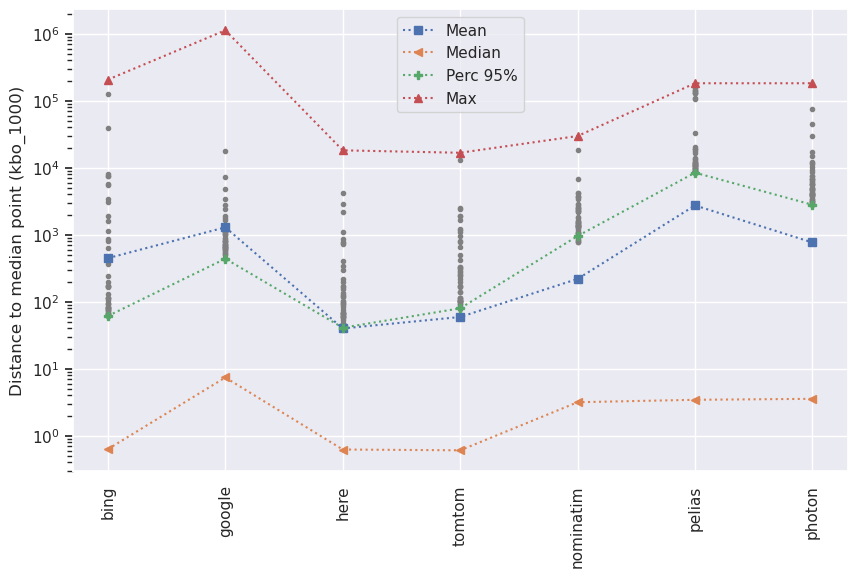

In [434]:
dist_to_median_line_plot(geocoded_data)

geocoder
bing          447.616088
google       1291.281446
here           39.988390
tomtom         59.269273
nominatim     219.399157
pelias       2742.957880
photon        766.932227
Name: Mean, dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


geocoder           bing        google          here        tomtom  \
Mean         447.616088  1.291281e+03     39.988390     59.269273   
Median         0.631989  7.410544e+00      0.623389      0.606691   
Perc 95%      61.298210  4.391161e+02     41.025180     79.808245   
Max       206864.059820  1.126672e+06  18209.215239  16745.382646   

geocoder     nominatim         pelias         photon  
Mean        219.399157    2742.957880     766.932227  
Median        3.167309       3.442388       3.559641  
Perc 95%    957.512910    8455.644575    2803.335688  
Max       29771.801128  182621.588386  182613.947514

geocoder
bing          94.682029
google        78.452674
here          20.935384
tomtom        59.846498
nominatim    163.568067
pelias        66.557525
photon       369.604394
Name: Mean, dtype: float64

geocoder          bing       google         here        tomtom    nominatim  \
Mean         94.682029    78.452674    20.935384     59.846498   163.568067   
Median        0.622383     7.533703     0.623389      0.613386     3.054204   
Perc 95%     54.306771   421.276344    39.836418     81.506421   892.159357   
Max       39372.065726  4874.635051  4196.452403  16745.382646  6892.625579   

geocoder        pelias        photon  
Mean         66.557525    369.604394  
Median        0.840111      3.314320  
Perc 95%    192.967816   2398.193310  
Max       10759.550586  17295.375190

geocoder
bing         0.980000
google       0.973000
here         0.990000
nominatim    0.964327
pelias       0.674022
photon       0.938816
tomtom       0.990000
Name: reference_key, dtype: float64

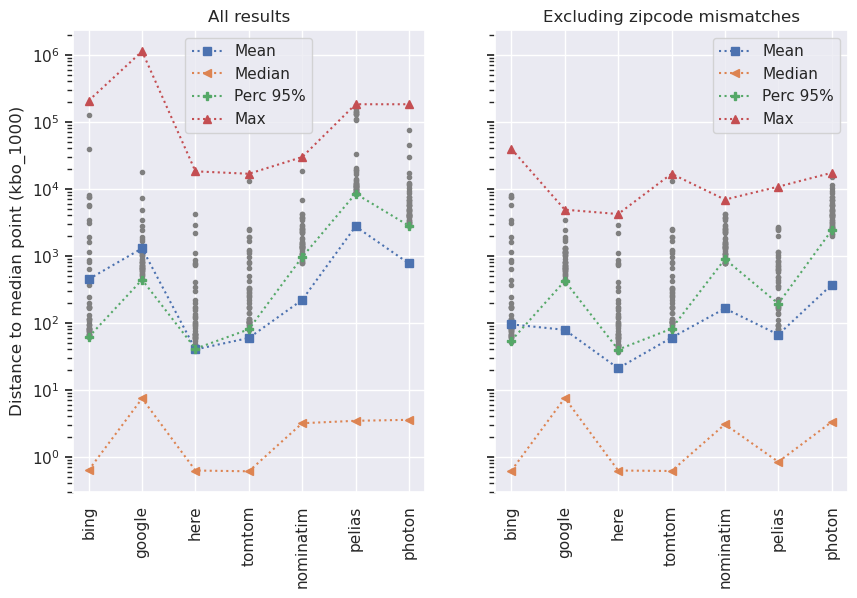

In [435]:
f, ax=plt.subplots(1,2, figsize=(12,5), sharey=True)
dist_to_median_line_plot(geocoded_data, ax[0], "All results")

# Keep only results containing input postcode (not fully accurate...)
d = geocoded_data[geocoded_data.apply(lambda rec: str(rec.postcode) in  str(rec.location.raw), axis=1)]

dist_to_median_line_plot(d, ax[1], "Excluding zipcode mismatches", legend=False)

d.groupby("geocoder").reference_key.count()/ geocoded_data.groupby("geocoder").reference_key.count()

geocoder
bing          447.616088
google       1291.281446
here           39.988390
tomtom         59.269273
nominatim     219.399157
pelias       2742.957880
photon        766.932227
Name: Mean, dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


geocoder           bing        google          here        tomtom  \
Mean         447.616088  1.291281e+03     39.988390     59.269273   
Median         0.631989  7.410544e+00      0.623389      0.606691   
Perc 95%      61.298210  4.391161e+02     41.025180     79.808245   
Max       206864.059820  1.126672e+06  18209.215239  16745.382646   

geocoder     nominatim         pelias         photon  
Mean        219.399157    2742.957880     766.932227  
Median        3.167309       3.442388       3.559641  
Perc 95%    957.512910    8455.644575    2803.335688  
Max       29771.801128  182621.588386  182613.947514

geocoder
bing          447.616088
google        106.669975
here           39.988390
tomtom         59.269273
nominatim     219.399157
pelias       2742.957880
photon        766.932227
Name: Mean, dtype: float64

geocoder           bing        google          here        tomtom  \
Mean         447.616088    106.669975     39.988390     59.269273   
Median         0.631989      7.402572      0.623389      0.606691   
Perc 95%      61.298210    430.995775     41.025180     79.808245   
Max       206864.059820  17838.981542  18209.215239  16745.382646   

geocoder     nominatim         pelias         photon  
Mean        219.399157    2742.957880     766.932227  
Median        3.167309       3.442388       3.559641  
Perc 95%    957.512910    8455.644575    2803.335688  
Max       29771.801128  182621.588386  182613.947514

geocoder
bing         1.000
google       0.999
here         1.000
nominatim    1.000
pelias       1.000
photon       1.000
tomtom       1.000
Name: reference_key, dtype: float64

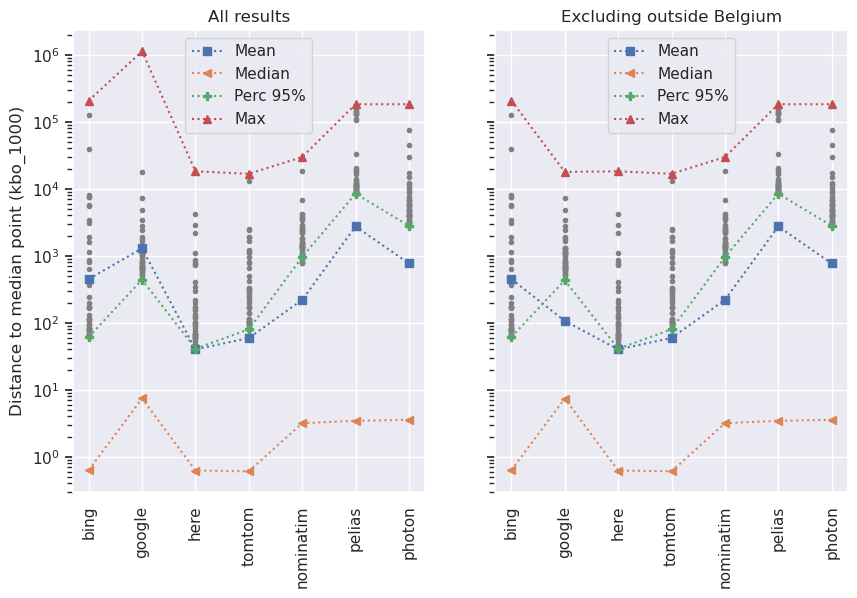

In [436]:
f, ax=plt.subplots(1,2, figsize=(12,5), sharey=True)
dist_to_median_line_plot(geocoded_data, ax[0], "All results")

# Keep only results containing input postcode (not fully accurate...)
d = geocoded_data[geocoded_data.is_in_belgium]

dist_to_median_line_plot(d, ax[1], "Excluding outside Belgium", legend=False)

d.groupby("geocoder").reference_key.count()/ geocoded_data.groupby("geocoder").reference_key.count()

geocoder
bing          447.616088
google       1291.281446
here           39.988390
tomtom         59.269273
nominatim     219.399157
pelias       2742.957880
photon        766.932227
Name: Mean, dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


geocoder           bing        google          here        tomtom  \
Mean         447.616088  1.291281e+03     39.988390     59.269273   
Median         0.631989  7.410544e+00      0.623389      0.606691   
Perc 95%      61.298210  4.391161e+02     41.025180     79.808245   
Max       206864.059820  1.126672e+06  18209.215239  16745.382646   

geocoder     nominatim         pelias         photon  
Mean        219.399157    2742.957880     766.932227  
Median        3.167309       3.442388       3.559641  
Perc 95%    957.512910    8455.644575    2803.335688  
Max       29771.801128  182621.588386  182613.947514

geocoder
bing         447.616088
google        92.008960
here          37.732196
tomtom        59.269273
nominatim    219.399157
pelias        80.603308
photon       700.311008
Name: Mean, dtype: float64

geocoder           bing        google          here        tomtom  \
Mean         447.616088     92.008960     37.732196     59.269273   
Median         0.631989      7.335489      0.623389      0.606691   
Perc 95%      61.298210    415.534161     39.851839     79.808245   
Max       206864.059820  17838.981542  18209.215239  16745.382646   

geocoder     nominatim       pelias         photon  
Mean        219.399157    80.603308     700.311008  
Median        3.167309     0.852021       3.456333  
Perc 95%    957.512910   226.097632    2242.896924  
Max       29771.801128  8821.610910  182613.947514

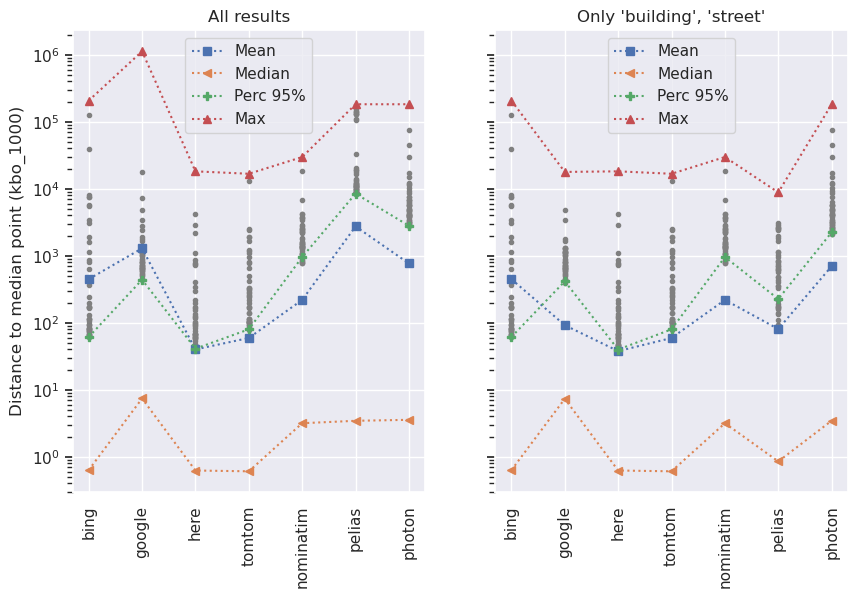

In [437]:
f, ax=plt.subplots(1,2, figsize=(12,5), sharey=True)
dist_to_median_line_plot(geocoded_data, ax[0], "All results")

# Keep only results containing input postcode (not fully accurate...)
d = geocoded_data[geocoded_data.precision.isin(["building", 'street'])]

dist_to_median_line_plot(d, ax[1], "Only 'building', 'street'")


geocoder
bing          447.616088
google       1291.281446
here           39.988390
tomtom         59.269273
nominatim     219.399157
pelias       2742.957880
photon        766.932227
Name: Mean, dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


geocoder           bing        google          here        tomtom  \
Mean         447.616088  1.291281e+03     39.988390     59.269273   
Median         0.631989  7.410544e+00      0.623389      0.606691   
Perc 95%      61.298210  4.391161e+02     41.025180     79.808245   
Max       206864.059820  1.126672e+06  18209.215239  16745.382646   

geocoder     nominatim         pelias         photon  
Mean        219.399157    2742.957880     766.932227  
Median        3.167309       3.442388       3.559641  
Perc 95%    957.512910    8455.644575    2803.335688  
Max       29771.801128  182621.588386  182613.947514

geocoder
bing          94.682029
google        73.948673
here          18.634918
tomtom        59.846498
nominatim    163.568067
pelias        50.282041
photon       294.240862
Name: Mean, dtype: float64

geocoder          bing       google         here        tomtom    nominatim  \
Mean         94.682029    73.948673    18.634918     59.846498   163.568067   
Median        0.622383     7.485520     0.622646      0.613386     3.054204   
Perc 95%     54.306771   397.505750    36.375668     81.506421   892.159357   
Max       39372.065726  4874.635051  4196.452403  16745.382646  6892.625579   

geocoder       pelias        photon  
Mean        50.282041    294.240862  
Median       0.833863      3.221716  
Perc 95%   177.967073   1344.915223  
Max       2660.136046  17295.375190

geocoder
bing         0.978000
google       0.969000
here         0.987000
nominatim    0.964327
pelias       0.673019
photon       0.917753
tomtom       0.989000
Name: reference_key, dtype: float64

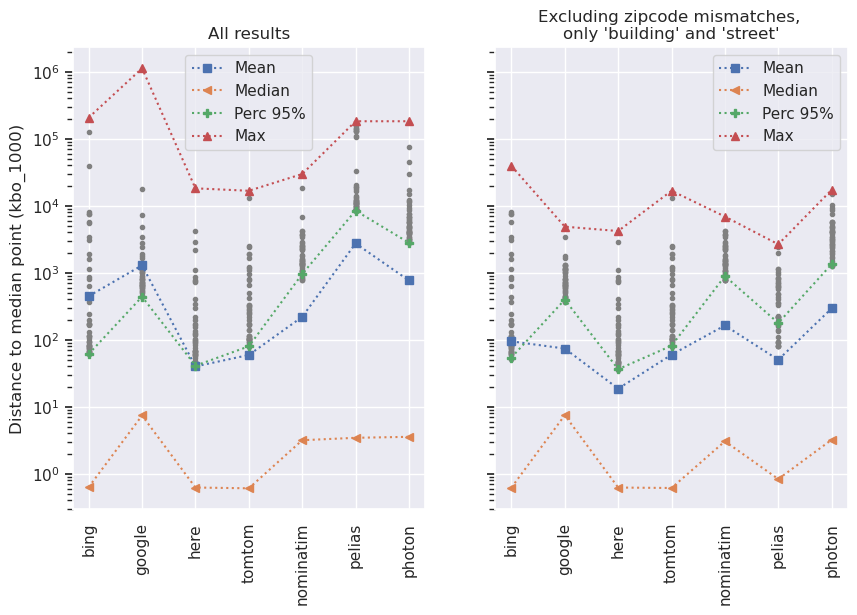

In [438]:
f, ax=plt.subplots(1,2, figsize=(12,5), sharey=True)
dist_to_median_line_plot(geocoded_data, ax[0], "All results")

# Keep only results containing input postcode (not fully accurate...)
d = geocoded_data[geocoded_data.precision.isin(["building", 'street']) & geocoded_data.apply(lambda rec: str(rec.postcode) in  str(rec.location.raw), axis=1)]

dist_to_median_line_plot(d, ax[1], "Excluding zipcode mismatches, \nonly 'building' and 'street'", legend=False)

d.groupby("geocoder").reference_key.count()/ geocoded_data.groupby("geocoder").reference_key.count()

In [439]:
# geocoded_data[~geocoded_data.apply(lambda rec: str(rec.postcode) in  str(rec.location.raw), axis=1)]

In [440]:
pdf.close()